/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
<ipython-input-101-9af18ddcb787>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(data)
<ipython-input-101-9af18ddcb787>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = stats.kurtosis(data)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1205: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/U

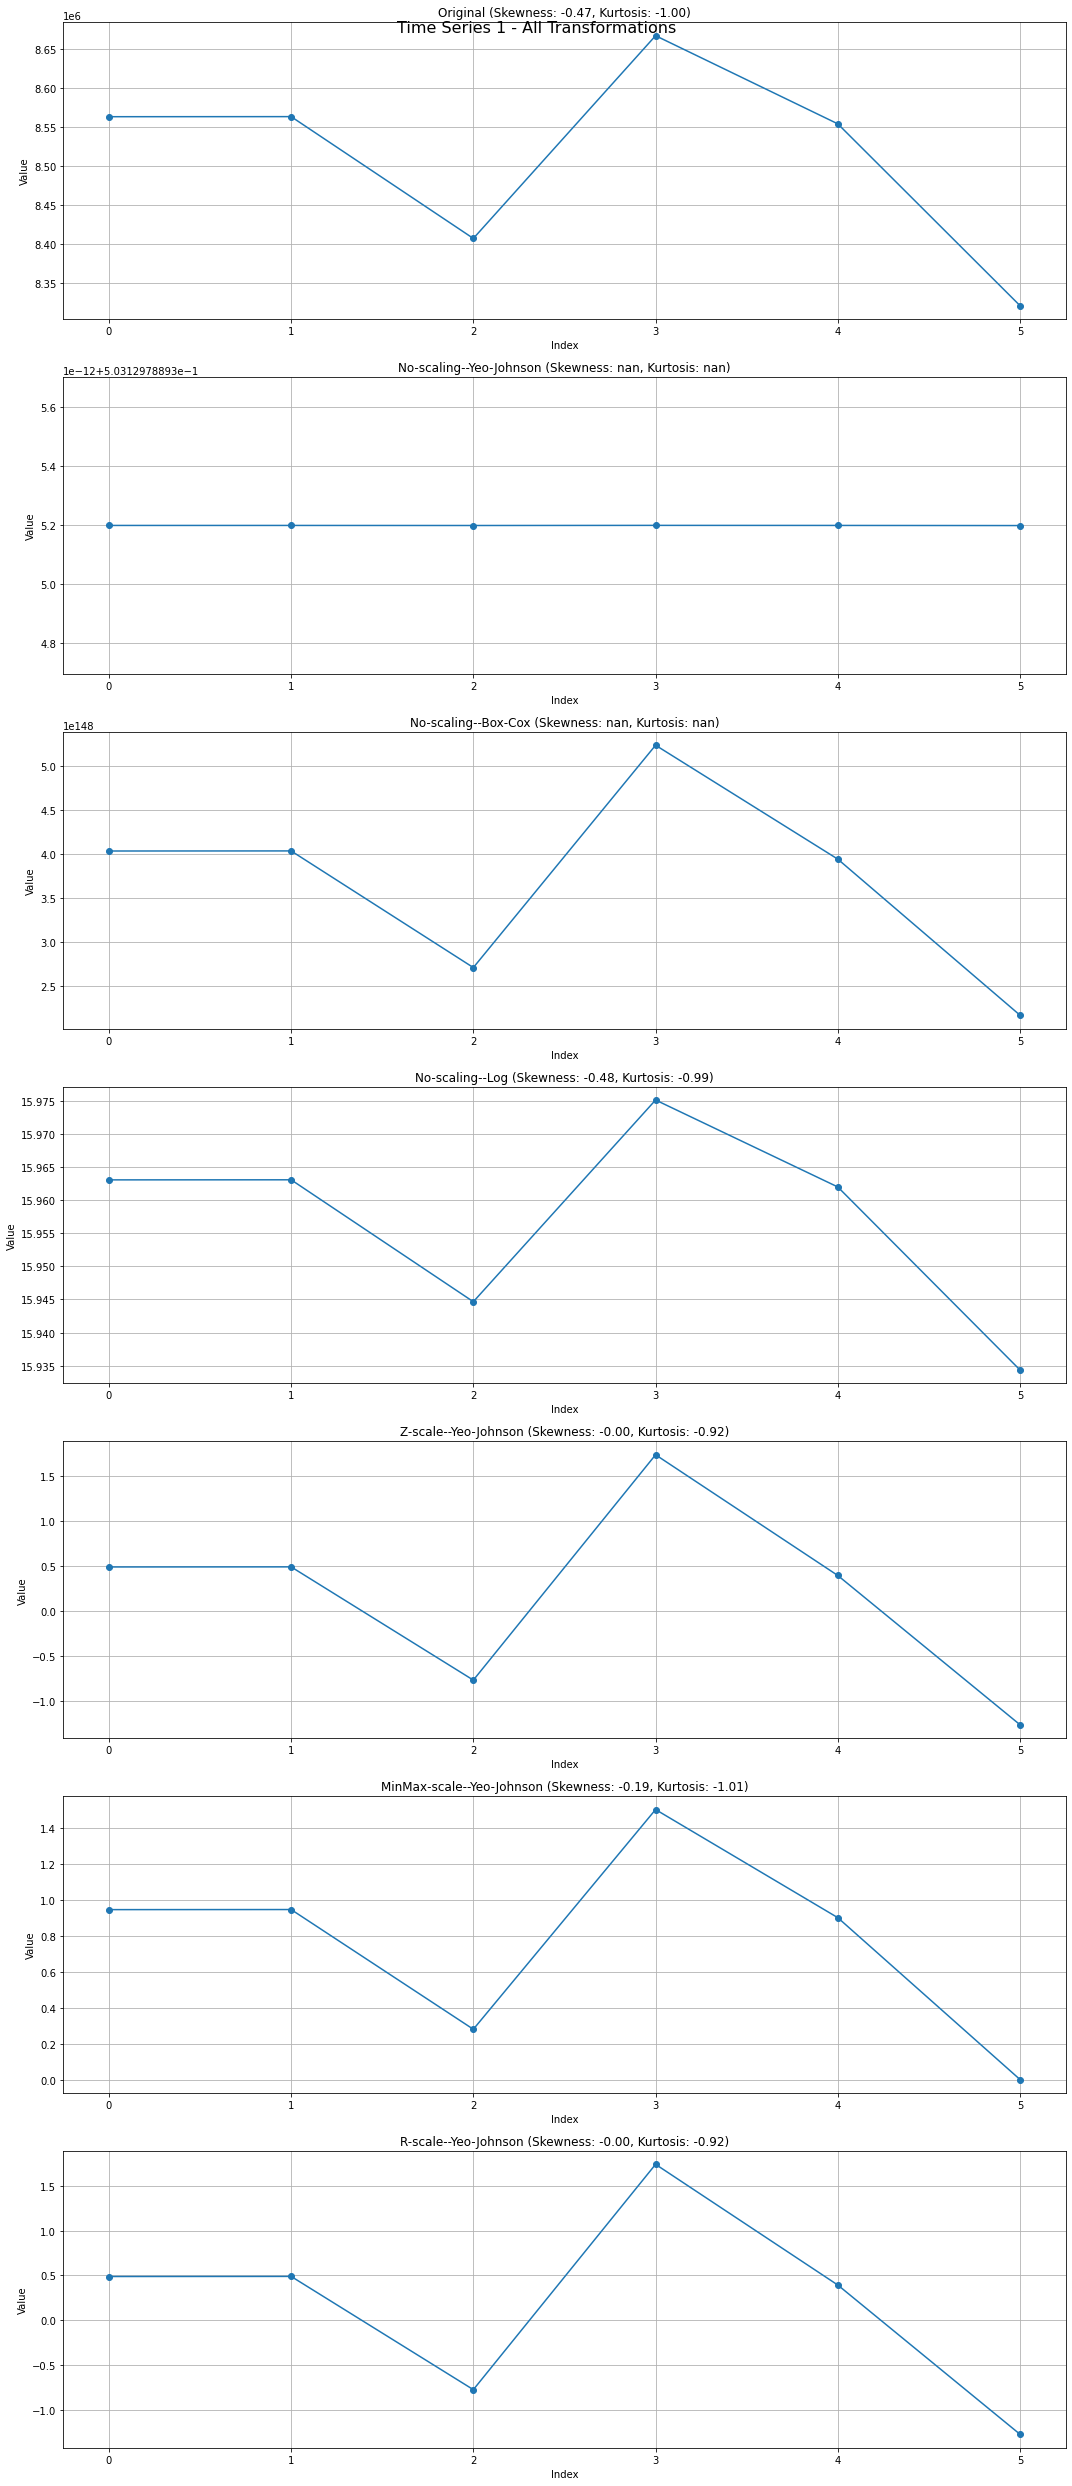

<ipython-input-101-9af18ddcb787>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(data)
<ipython-input-101-9af18ddcb787>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = stats.kurtosis(data)


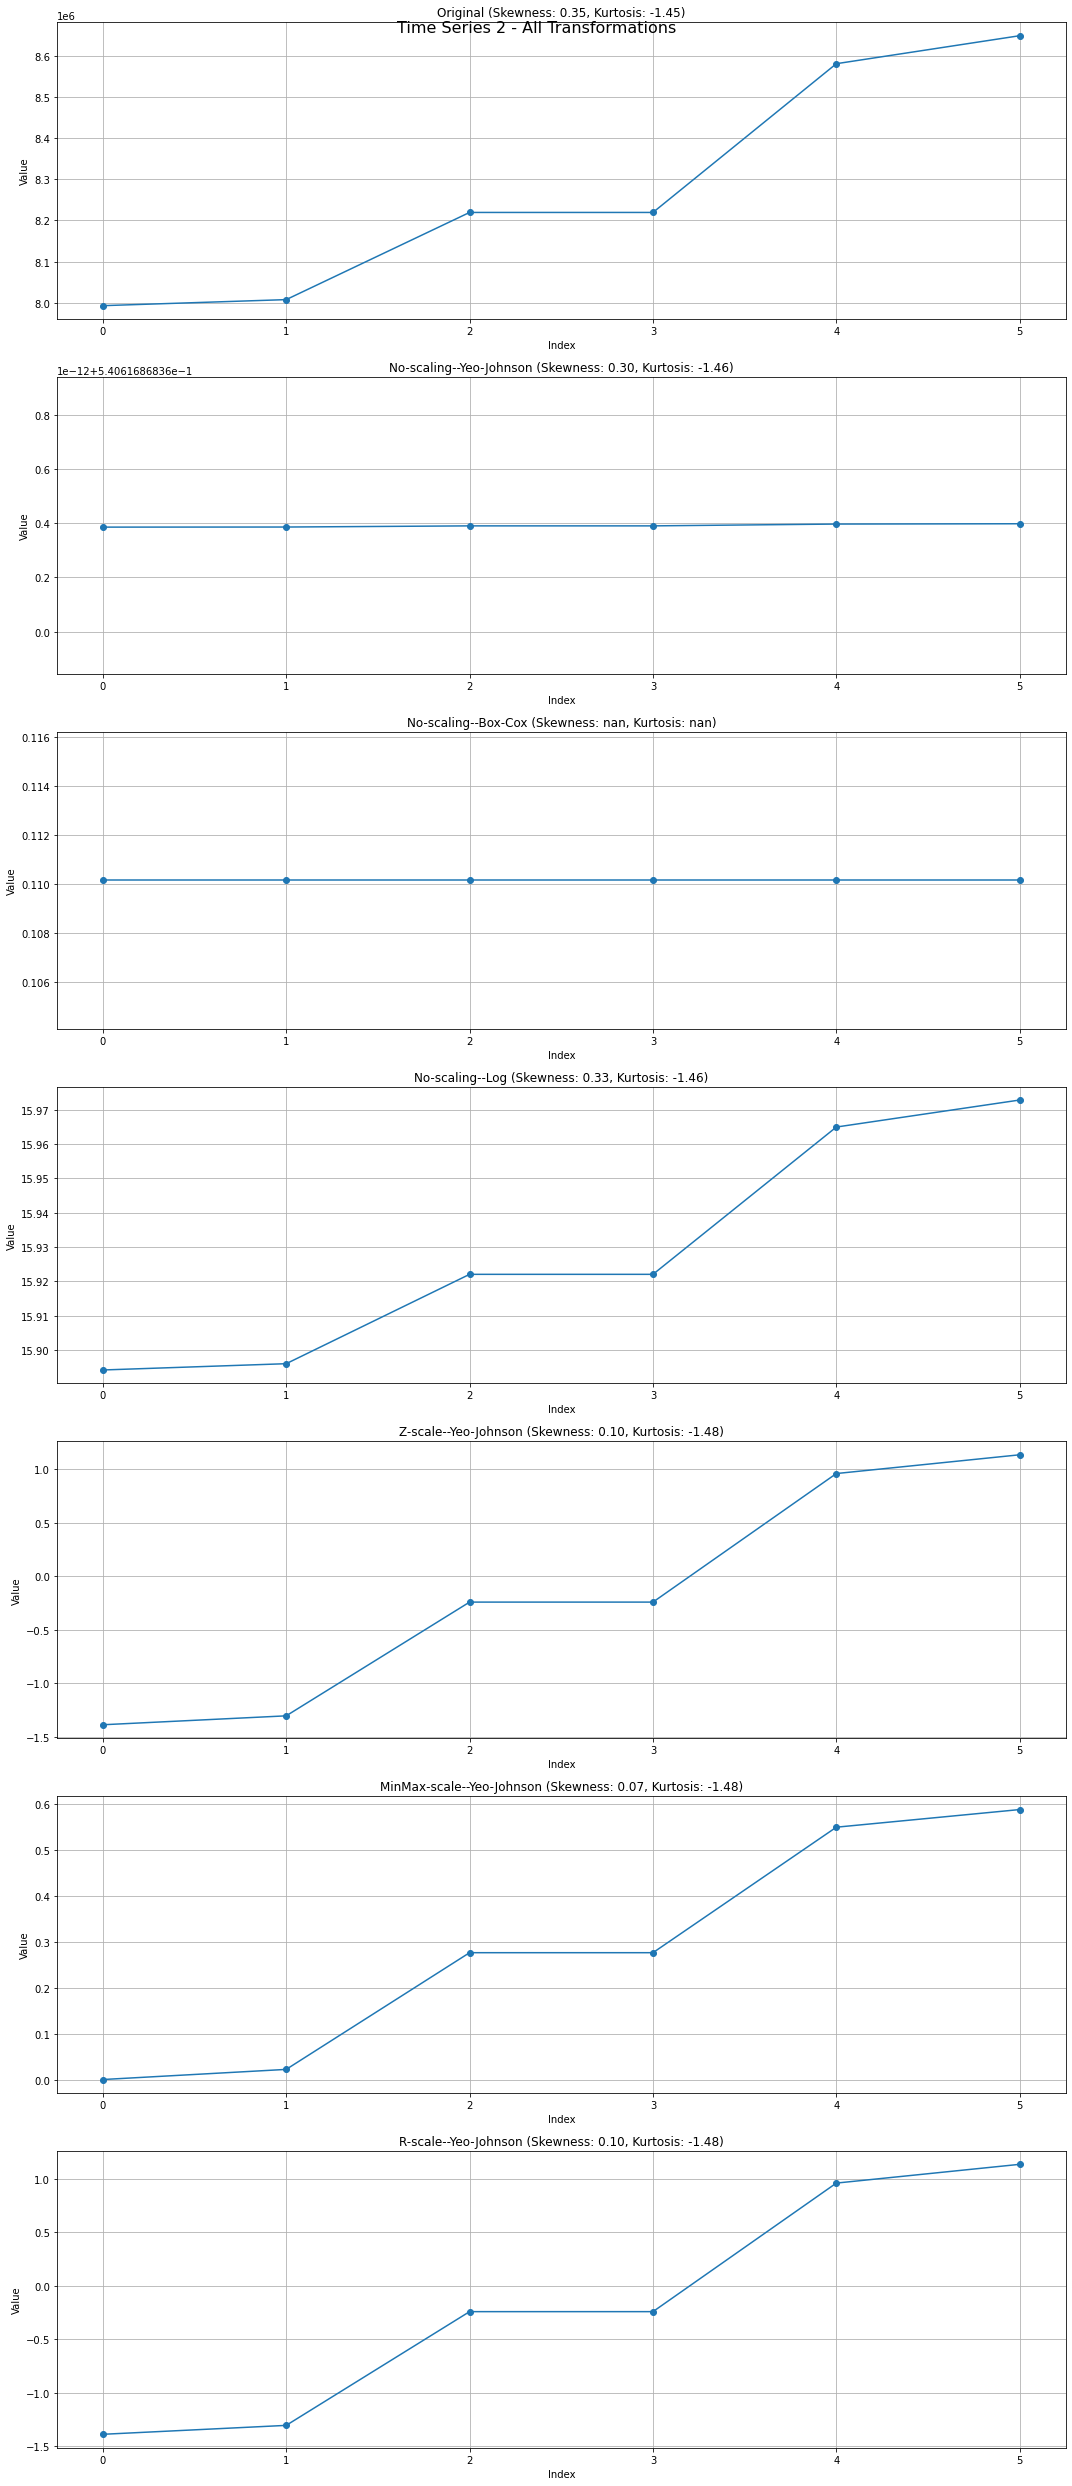

<ipython-input-101-9af18ddcb787>:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = stats.skew(data)
<ipython-input-101-9af18ddcb787>:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = stats.kurtosis(data)


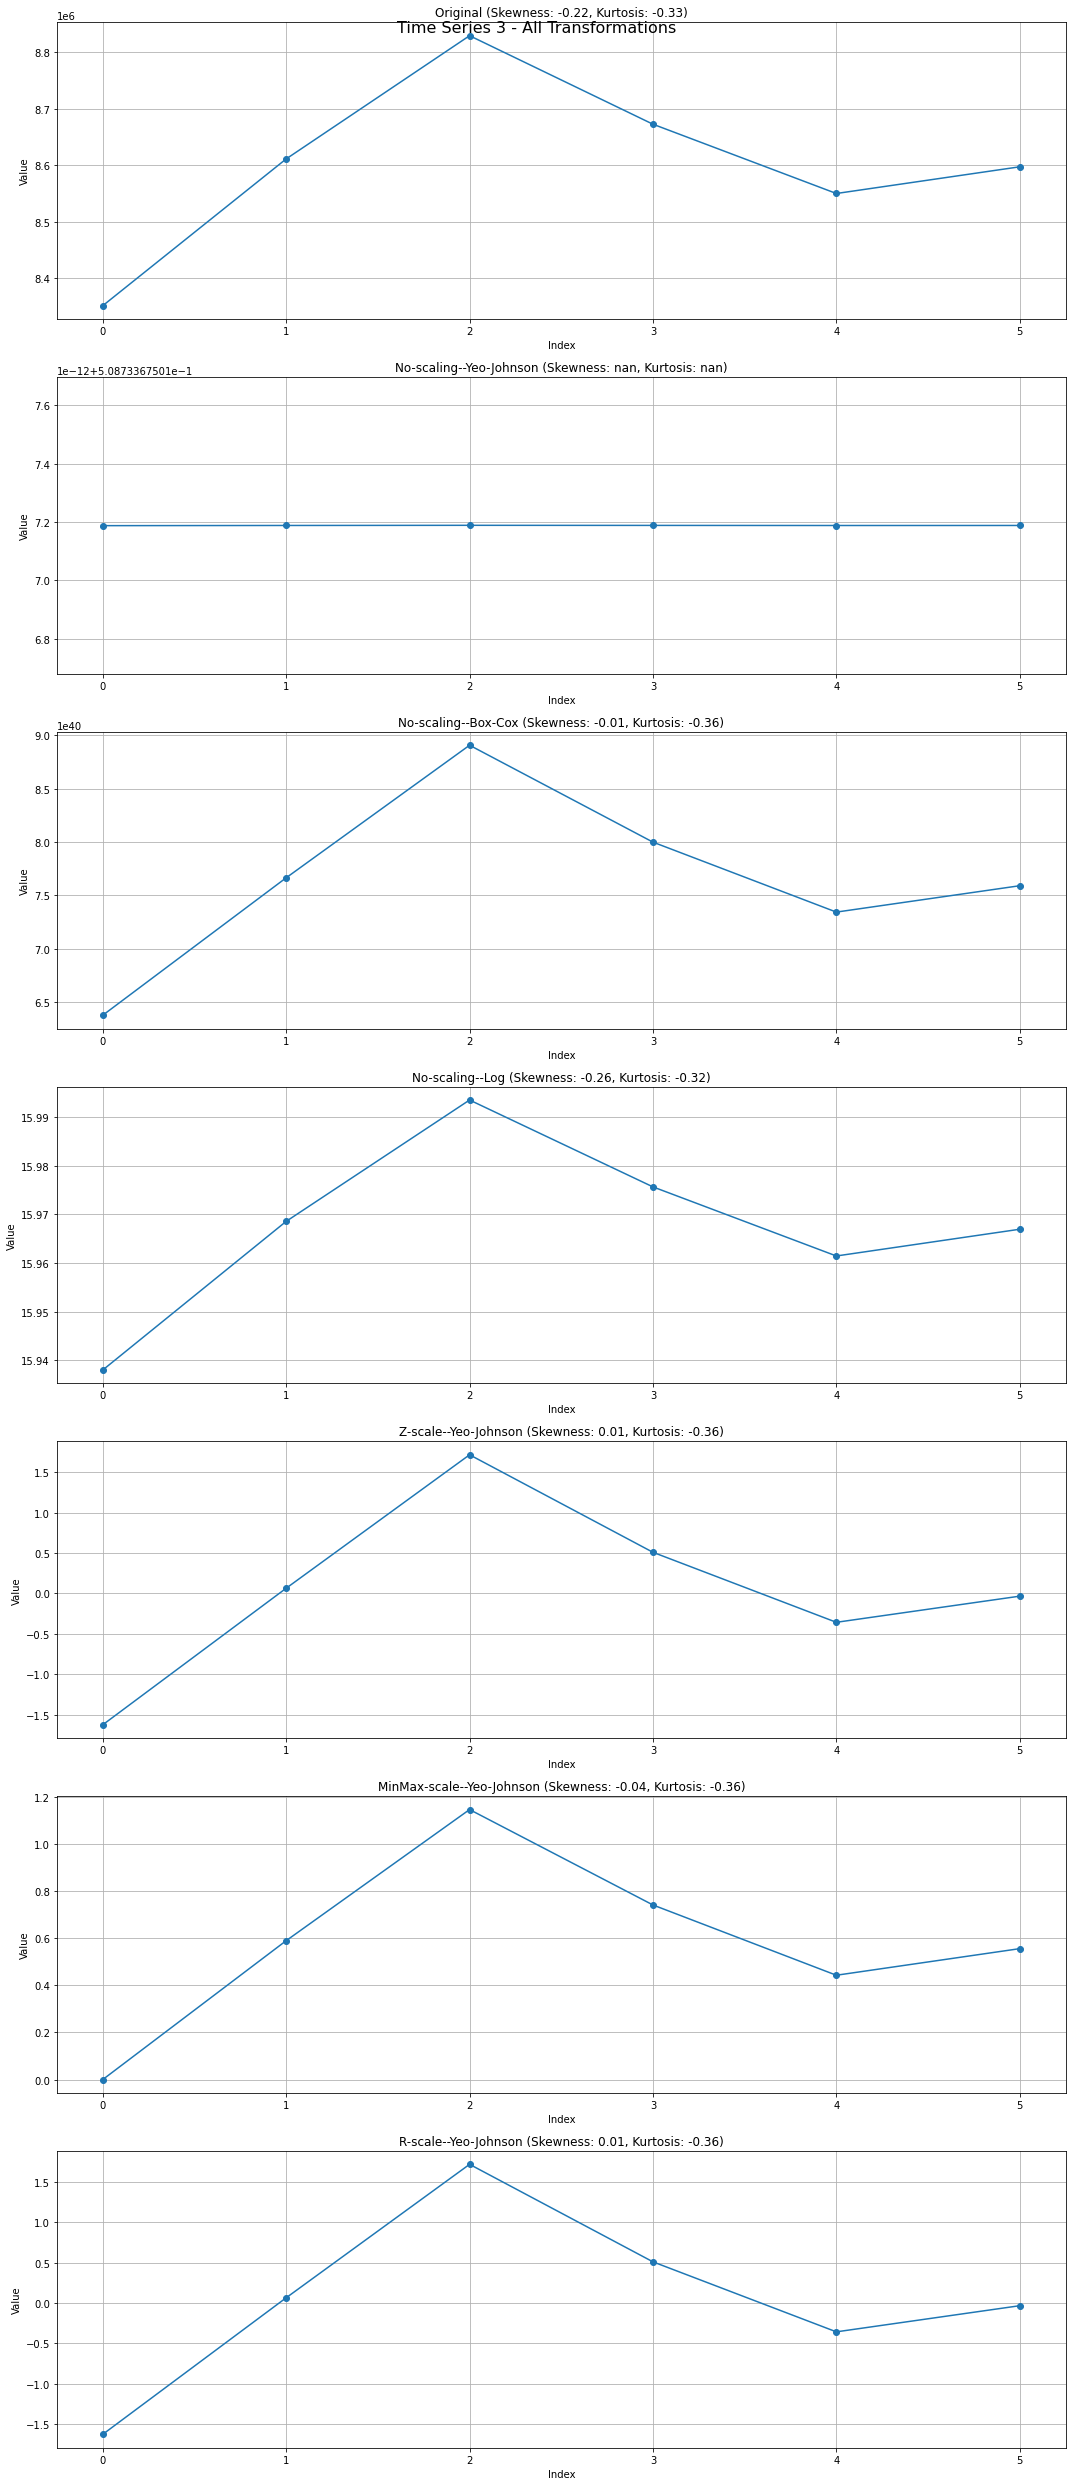

Best transformation: Z-scale--Yeo-Johnson

Summary of transformations:
              Transformation  Average Skewness  Average Kurtosis
4       Z-scale--Yeo-Johnson          0.034188         -0.920382
6       R-scale--Yeo-Johnson          0.034188         -0.920382
5  MinMax-scale--Yeo-Johnson         -0.055920         -0.951901
0                   Original         -0.109754         -0.928831
3            No-scaling--Log         -0.134941         -0.925154
1    No-scaling--Yeo-Johnson               NaN               NaN
2        No-scaling--Box-Cox               NaN               NaN


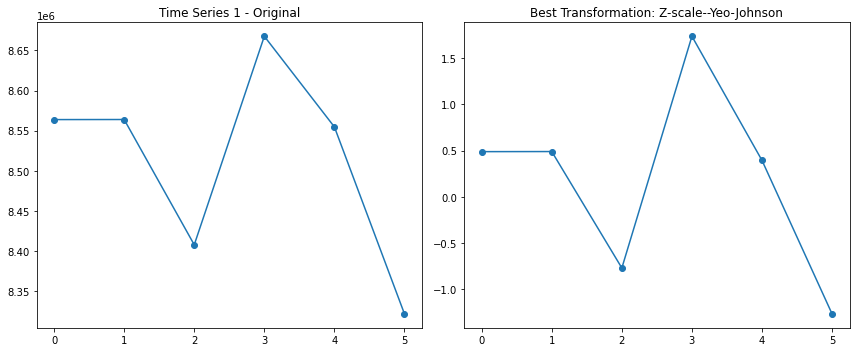

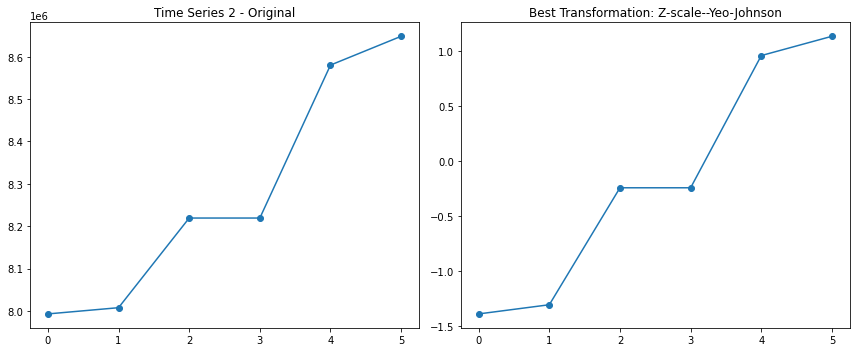

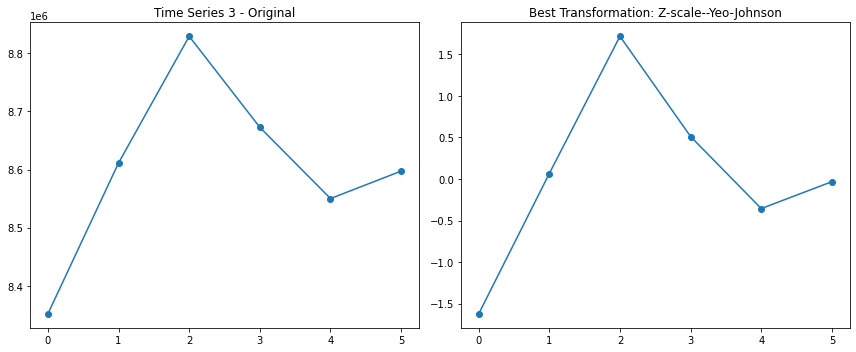


Final transformed data:
Time Series 1:
[ 0.48820338  0.48924248 -0.77175901  1.7374169   0.39322216 -1.26894731]
Time Series 2:
[-1.3884188  -1.30512443 -0.24305754 -0.24305754  0.95738737  1.13256352]
Time Series 3:
[-1.62324803  0.06504394  1.71524477  0.50938764 -0.35632134 -0.0329891 ]


In [101]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler,RobustScaler

def calculate_stats(data):
    skewness = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    return skewness, kurtosis

def apply_power_transformations(data, prefix=''):
    transformations = {}
    pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    transformations[f'{prefix}Yeo-Johnson'] = pt_yj.fit_transform(data.reshape(-1, 1)).flatten()
    
    if np.all(data > 0):
        pt_bc = PowerTransformer(method='box-cox', standardize=False)
        transformations[f'{prefix}Box-Cox'] = pt_bc.fit_transform(data.reshape(-1, 1)).flatten()
        transformations[f'{prefix}Log'] = np.log(data)
    else:
        print(f"Warning: {prefix}Box-Cox and {prefix}Log transformations not applied due to non-positive values.")
    
    return transformations

def transform_timeseries(timeseries):
    transformations = {'Original': timeseries}
    
    # No pre-scaling
    transformations.update(apply_power_transformations(timeseries, 'No-scaling--'))
    
    # Z-scale pre-scaling
    ss = StandardScaler()
    z_scaled = ss.fit_transform(timeseries.reshape(-1, 1)).flatten()
    transformations.update(apply_power_transformations(z_scaled, 'Z-scale--'))
    
    # MinMax-scale pre-scaling
    mms = MinMaxScaler()
    minmax_scaled = mms.fit_transform(timeseries.reshape(-1, 1)).flatten()
    transformations.update(apply_power_transformations(minmax_scaled, 'MinMax-scale--'))
    
    # R-scale pre-scaling
    rs = RobustScaler()
    r_scaled = rs.fit_transform(timeseries.reshape(-1, 1)).flatten()
    transformations.update(apply_power_transformations(z_scaled, 'R-scale--'))
    # Calculate skewness and kurtosis for each transformation
    stats_results = {name: calculate_stats(data) for name, data in transformations.items()}

    return transformations, stats_results

def calculate_average_statistics(all_stats):
    average_stats = {}
    for method in all_stats[0].keys():
        skewness_values = [stats[method][0] for stats in all_stats if method in stats]
        kurtosis_values = [stats[method][1] for stats in all_stats if method in stats]
        average_stats[method] = (np.mean(skewness_values), np.mean(kurtosis_values))
    return average_stats

def select_best_transformation(average_stats):
    return min(average_stats.items(), key=lambda x: abs(x[1][0]))

def visualize_transformations(timeseries, transformations, stats_results, index):
    n_transformations = len(transformations)
    fig, axs = plt.subplots(n_transformations, 1, figsize=(15, 5 * n_transformations))
    fig.suptitle(f'Time Series {index + 1} - All Transformations', fontsize=16)

    for i, (name, data) in enumerate(transformations.items()):
        axs[i].plot(data, marker='o')
        axs[i].set_title(f'{name} (Skewness: {stats_results[name][0]:.2f}, Kurtosis: {stats_results[name][1]:.2f})')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('Value')
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

def analyze_multiple_timeseries(list_of_timeseries):
    all_stats = []
    all_transformations = []

    for i, timeseries in enumerate(list_of_timeseries):
        transformations, stats_results = transform_timeseries(timeseries)
        all_stats.append(stats_results)
        all_transformations.append(transformations)
        
        visualize_transformations(timeseries, transformations, stats_results, i)

    average_stats = calculate_average_statistics(all_stats)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': skewness, 
         'Average Kurtosis': kurtosis}
        for method, (skewness, kurtosis) in average_stats.items()
    ]).sort_values(by='Average Skewness', key=abs)

    return best_transformation, summary_df, all_transformations

def apply_final_transformation(list_of_timeseries, best_transformation, all_transformations):
    final_transformed_data = []

    for i, timeseries in enumerate(list_of_timeseries):
        best_transformed = all_transformations[i][best_transformation]
        final_transformed_data.append(best_transformed)

        # Visualize original and best transformation
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.plot(timeseries, marker='o')
        plt.title(f'Time Series {i+1} - Original')
        plt.subplot(122)
        plt.plot(best_transformed, marker='o')
        plt.title(f'Best Transformation: {best_transformation}')
        plt.tight_layout()
        plt.show()

    return final_transformed_data

# Example usage
timeseries1 = np.array([8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53])
timeseries2 = np.array([7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63])
timeseries3 = np.array([8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15])

list_of_timeseries = [timeseries1, timeseries2, timeseries3]

best_transformation, summary_df, all_transformations = analyze_multiple_timeseries(list_of_timeseries)

print(f"Best transformation: {best_transformation}")
print("\nSummary of transformations:")
print(summary_df)

final_transformed_data = apply_final_transformation(list_of_timeseries, best_transformation, all_transformations)

print("\nFinal transformed data:")
for i, data in enumerate(final_transformed_data):
    print(f"Time Series {i+1}:")
    print(data)

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

def calculate_stats(data):
    skewness = stats.skew(data, axis=0)
    kurtosis = stats.kurtosis(data, axis=0)
    return skewness, kurtosis

def apply_power_transformations(data, prefix=''):
    transformations = {}
    pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    transformations[f'{prefix}Yeo-Johnson'] = pt_yj.fit_transform(data)
    
    if np.all(data > 0):
        pt_bc = PowerTransformer(method='box-cox', standardize=False)
        transformations[f'{prefix}Box-Cox'] = pt_bc.fit_transform(data)
    else:
        print(f"Warning: {prefix}Box-Cox transformation not applied due to non-positive values.")
    
    return transformations

def transform_timeseries(timeseries_data):
    transformations = {'Original': timeseries_data}
    
    # No pre-scaling
    transformations.update(apply_power_transformations(timeseries_data, 'No-scaling--'))
    
    # Z-scale pre-scaling
    ss = StandardScaler()
    z_scaled = ss.fit_transform(timeseries_data)
    transformations.update(apply_power_transformations(z_scaled, 'Z-scale--'))
    
    # MinMax-scale pre-scaling
    mms = MinMaxScaler()
    minmax_scaled = mms.fit_transform(timeseries_data)
    transformations.update(apply_power_transformations(minmax_scaled, 'MinMax-scale--'))

    # Log pre-scaling
    if np.all(timeseries_data > 0):
        log_scaled = np.log(timeseries_data)
        transformations.update(apply_power_transformations(log_scaled, 'Log-scale--'))
    else:
        print("Warning: Log pre-scaling not applied due to non-positive values.")

    # Quantile transform
    qt = QuantileTransformer(output_distribution='normal')
    transformations['Quantile'] = qt.fit_transform(timeseries_data)

    # Calculate skewness and kurtosis for each transformation
    stats_results = {name: calculate_stats(data) for name, data in transformations.items()}

    return transformations, stats_results

def calculate_average_statistics(stats_results):
    average_stats = {}
    for method, (skewness, kurtosis) in stats_results.items():
        average_stats[method] = (np.mean(skewness), np.mean(kurtosis))
    return average_stats

def select_best_transformation(average_stats):
    return min(average_stats.items(), key=lambda x: np.mean(np.abs(x[1][0])))

def visualize_transformations(transformations, stats_results, series_names):
    n_transformations = len(transformations)
    n_series = transformations['Original'].shape[1]
    fig, axs = plt.subplots(n_transformations, 1, figsize=(15, 5 * n_transformations))
    fig.suptitle(f'All Transformations', fontsize=16)

    for i, (name, data) in enumerate(transformations.items()):
        for j in range(n_series):
            axs[i].plot(data[:, j], label=series_names[j])
        axs[i].set_title(f'{name} (Avg Skewness: {np.mean(stats_results[name][0]):.2f}, Avg Kurtosis: {np.mean(stats_results[name][1]):.2f})')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('Value')
        axs[i].grid(True)
        if i == 0:  # Only show legend for the first subplot to avoid clutter
            axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def apply_final_transformation(timeseries_data, best_transformation):
    if best_transformation == 'Quantile':
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data = qt.fit_transform(timeseries_data)
    else:
        # Extract the pre-scaling method and power transform method
        pre_scaling, power_transform = best_transformation.split('--')

        # Apply pre-scaling
        if pre_scaling == 'No-scaling':
            scaled_data = timeseries_data
        elif pre_scaling == 'Z-scale':
            ss = StandardScaler()
            scaled_data = ss.fit_transform(timeseries_data)
        elif pre_scaling == 'MinMax-scale':
            mms = MinMaxScaler()
            scaled_data = mms.fit_transform(timeseries_data)
        elif pre_scaling == 'Log-scale':
            if np.all(timeseries_data > 0):
                scaled_data = np.log(timeseries_data)
            else:
                raise ValueError("Log pre-scaling requires positive values")
        else:
            raise ValueError(f"Unknown pre-scaling method: {pre_scaling}")

        # Apply power transform
        if power_transform == 'Yeo-Johnson':
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_data = pt.fit_transform(scaled_data)
        elif power_transform == 'Box-Cox':
            if np.all(scaled_data > 0):
                pt = PowerTransformer(method='box-cox', standardize=False)
                transformed_data = pt.fit_transform(scaled_data)
            else:
                raise ValueError("Box-Cox transform requires positive values")
        else:
            raise ValueError(f"Unknown power transform method: {power_transform}")

    # Apply final z-scoring
    final_ss = StandardScaler()
    final_transformed_data = final_ss.fit_transform(transformed_data)

    return final_transformed_data
def analyze_multiple_timeseries(list_of_timeseries):
    all_stats = []
    all_transformations = []

    for i, timeseries in enumerate(list_of_timeseries):
        transformations, stats_results = transform_timeseries(timeseries)
        all_stats.append(stats_results)
        all_transformations.append(transformations)
        
        visualize_transformations(timeseries, transformations, stats_results, i)

    average_stats = calculate_average_statistics(all_stats)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': skewness, 
         'Average Kurtosis': kurtosis}
        for method, (skewness, kurtosis) in average_stats.items()
    ]).sort_values(by='Average Skewness', key=abs)

    return best_transformation, summary_df, all_transformations
def analyze_timeseries(timeseries_data, series_names):
    transformations, stats_results = transform_timeseries(timeseries_data)
    
    visualize_transformations(transformations, stats_results, series_names)

    average_stats = calculate_average_statistics(stats_results)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': np.mean(skewness), 
         'Average Kurtosis': np.mean(kurtosis)}
        for method, (skewness, kurtosis) in average_stats.items()
    ]).sort_values(by='Average Skewness', key=lambda x: np.abs(x))

    final_transformed_data = apply_final_transformation(timeseries_data, best_transformation)

    return best_transformation, summary_df, final_transformed_data

# Original time series
timeseries1 = np.array([8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53])
timeseries2 = np.array([7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63])
timeseries3 = np.array([8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15])

list_of_timeseries = [timeseries1, timeseries2, timeseries3]
series_names = ['Original 1', 'Original 2', 'Original 3']

best_transformation, summary_df, final_transformed_data = analyze_timeseries(list_of_timeseries, series_names)

print(f"Best transformation: {best_transformation}")
print("\nSummary of transformations:")
print(summary_df)

print("\nShape of final transformed data:", final_transformed_data.shape)

# Visualize original vs final transformed data
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.title("Original Data")
for i in range(all_series.shape[1]):
    plt.plot(all_series[:, i], label=series_names[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Value')

plt.subplot(212)
plt.title(f"Final Transformed Data (Best: {best_transformation})")
for i in range(final_transformed_data.shape[1]):
    plt.plot(final_transformed_data[:, i], label=series_names[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3211: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda


TypeError: '>' not supported between instances of 'list' and 'int'

/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:3211: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/scipy/stats/_morestats.py:913: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWar

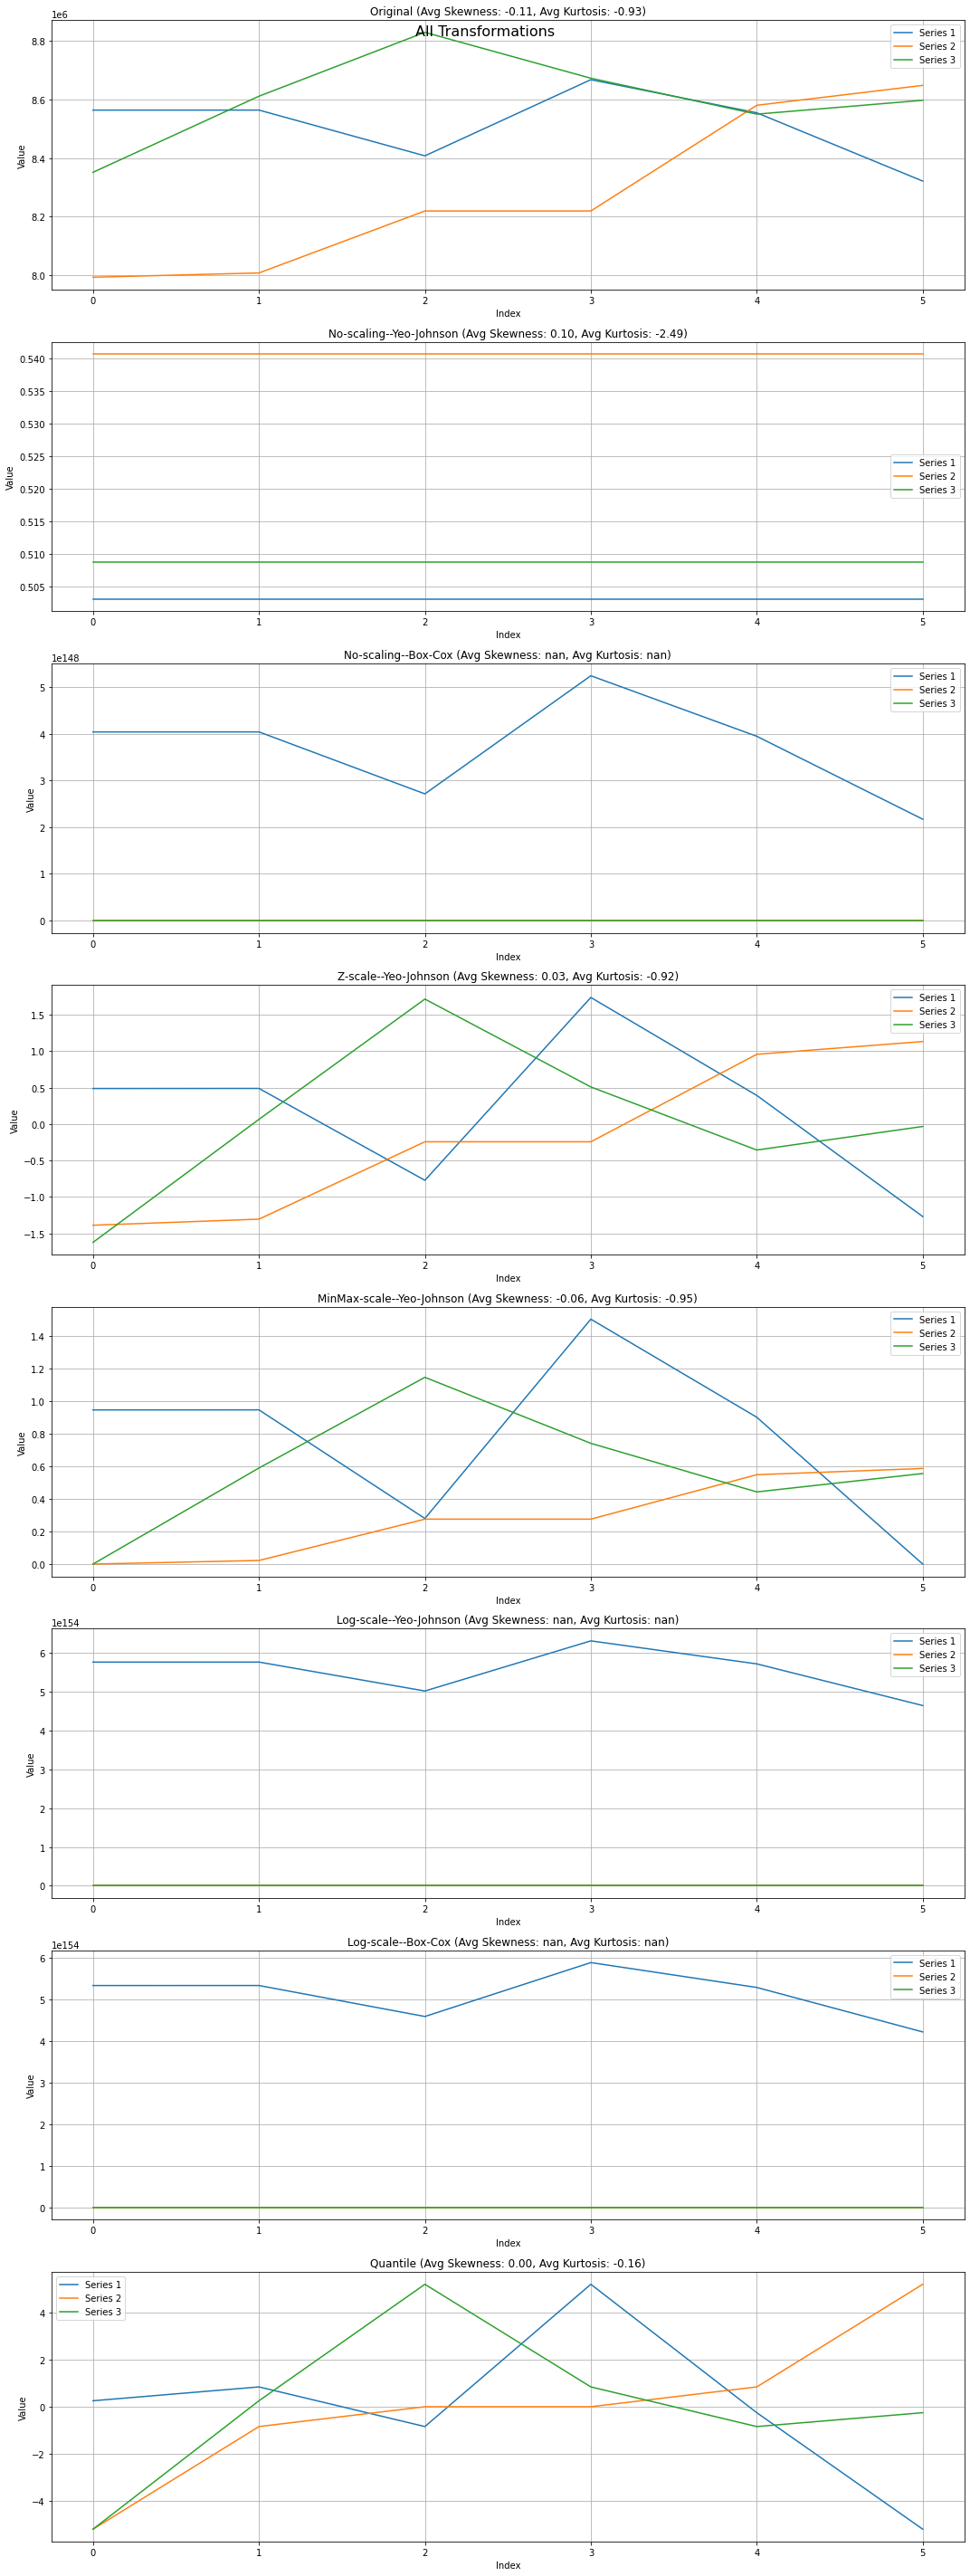

Decision Table for Selecting the Best Transformation (Ranked by Absolute Skewness):
 Rank            Transformation  Average Skewness  Average Kurtosis
    1                  Quantile      3.084726e-11         -0.158040
    2      Z-scale--Yeo-Johnson      3.418811e-02         -0.920382
    3 MinMax-scale--Yeo-Johnson     -5.592037e-02         -0.951901
    4   No-scaling--Yeo-Johnson      1.002075e-01         -2.487328
    5                  Original     -1.097535e-01         -0.928831
    6       No-scaling--Box-Cox               NaN               NaN
    7    Log-scale--Yeo-Johnson               NaN               NaN
    8        Log-scale--Box-Cox               NaN               NaN

Best transformation: Quantile


/Users/romanroman/miniforge3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


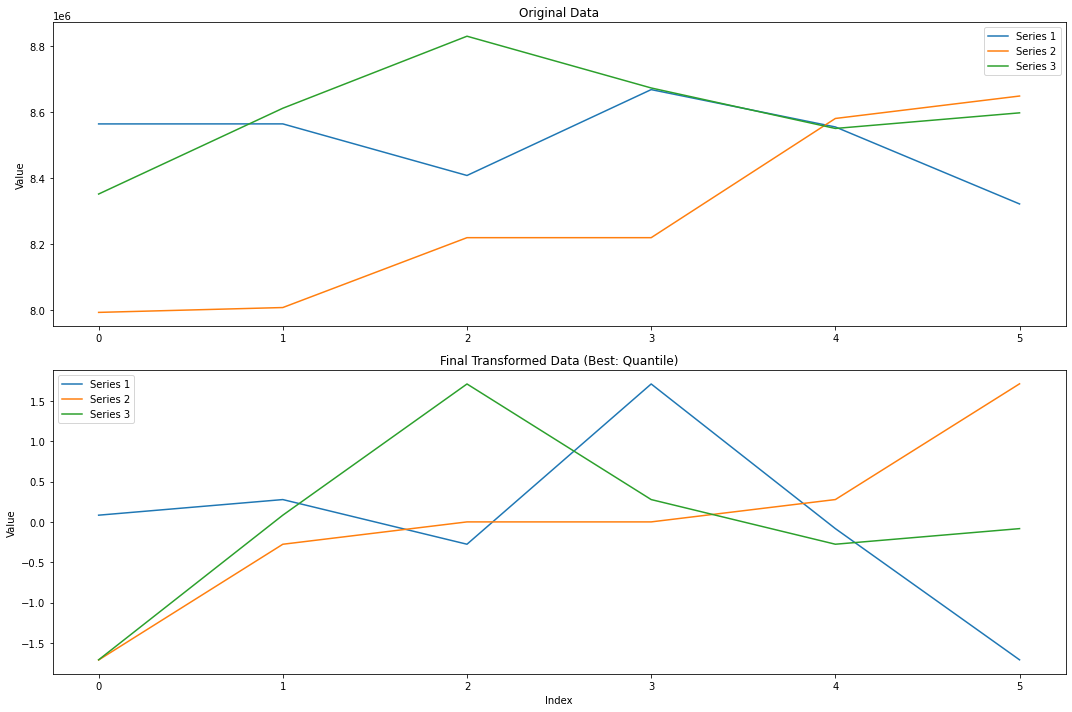

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

def calculate_stats(data):
    skewness = stats.skew(data, axis=0)
    kurtosis = stats.kurtosis(data, axis=0)
    return skewness, kurtosis

def apply_power_transformations(data, prefix=''):
    transformations = {}
    pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    transformations[f'{prefix}Yeo-Johnson'] = pt_yj.fit_transform(data)
    
    if np.all(data > 0):
        pt_bc = PowerTransformer(method='box-cox', standardize=False)
        transformations[f'{prefix}Box-Cox'] = pt_bc.fit_transform(data)
    else:
        print(f"Warning: {prefix}Box-Cox transformation not applied due to non-positive values.")
    
    return transformations

def transform_timeseries(data):
    transformations = {'Original': data}
    
    # No pre-scaling
    transformations.update(apply_power_transformations(data, 'No-scaling--'))
    
    # Z-scale pre-scaling
    ss = StandardScaler()
    z_scaled = ss.fit_transform(data)
    transformations.update(apply_power_transformations(z_scaled, 'Z-scale--'))
    
    # MinMax-scale pre-scaling
    mms = MinMaxScaler()
    minmax_scaled = mms.fit_transform(data)
    transformations.update(apply_power_transformations(minmax_scaled, 'MinMax-scale--'))

    # Log pre-scaling
    if np.all(data > 0):
        log_scaled = np.log(data)
        transformations.update(apply_power_transformations(log_scaled, 'Log-scale--'))
    else:
        print("Warning: Log pre-scaling not applied due to non-positive values.")

    # Quantile transform
    qt = QuantileTransformer(output_distribution='normal')
    transformations['Quantile'] = qt.fit_transform(data)

    # Calculate skewness and kurtosis for each transformation
    stats_results = {name: calculate_stats(transformed_data) for name, transformed_data in transformations.items()}

    return transformations, stats_results

def calculate_average_statistics(stats_results):
    average_stats = {}
    for method, (skewness, kurtosis) in stats_results.items():
        average_stats[method] = (np.mean(skewness), np.mean(kurtosis))
    return average_stats

def select_best_transformation(average_stats):
    return min(average_stats.items(), key=lambda x: np.mean(np.abs(x[1][0])))

def visualize_transformations(transformations, stats_results):
    n_transformations = len(transformations)
    n_series = transformations['Original'].shape[1]
    fig, axs = plt.subplots(n_transformations, 1, figsize=(15, 5 * n_transformations))
    fig.suptitle(f'All Transformations', fontsize=16)

    for i, (name, data) in enumerate(transformations.items()):
        for j in range(n_series):
            axs[i].plot(data[:, j], label=f'Series {j+1}')
        axs[i].set_title(f'{name} (Avg Skewness: {np.mean(stats_results[name][0]):.2f}, Avg Kurtosis: {np.mean(stats_results[name][1]):.2f})')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('Value')
        axs[i].grid(True)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def apply_final_transformation(data, best_transformation):
    if best_transformation == 'Quantile':
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data = qt.fit_transform(data)
    else:
        # Extract the pre-scaling method and power transform method
        pre_scaling, power_transform = best_transformation.split('--')

        # Apply pre-scaling
        if pre_scaling == 'No-scaling':
            scaled_data = data
        elif pre_scaling == 'Z-scale':
            ss = StandardScaler()
            scaled_data = ss.fit_transform(data)
        elif pre_scaling == 'MinMax-scale':
            mms = MinMaxScaler()
            scaled_data = mms.fit_transform(data)
        elif pre_scaling == 'Log-scale':
            if np.all(data > 0):
                scaled_data = np.log(data)
            else:
                raise ValueError("Log pre-scaling requires positive values")
        else:
            raise ValueError(f"Unknown pre-scaling method: {pre_scaling}")

        # Apply power transform
        if power_transform == 'Yeo-Johnson':
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_data = pt.fit_transform(scaled_data)
        elif power_transform == 'Box-Cox':
            if np.all(scaled_data > 0):
                pt = PowerTransformer(method='box-cox', standardize=False)
                transformed_data = pt.fit_transform(scaled_data)
            else:
                raise ValueError("Box-Cox transform requires positive values")
        else:
            raise ValueError(f"Unknown power transform method: {power_transform}")

    # Apply final z-scoring
    final_ss = StandardScaler()
    final_transformed_data = final_ss.fit_transform(transformed_data)

    return final_transformed_data

def analyze_timeseries(data):
    transformations, stats_results = transform_timeseries(data)
    
    visualize_transformations(transformations, stats_results)

    average_stats = calculate_average_statistics(stats_results)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    # Create summary DataFrame with ranking
    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': np.mean(skewness), 
         'Average Kurtosis': np.mean(kurtosis)}
        for method, (skewness, kurtosis) in stats_results.items()
    ])
    
    # Sort by absolute value of Average Skewness and add Rank column
    summary_df['Abs Skewness'] = summary_df['Average Skewness'].abs()
    summary_df = summary_df.sort_values('Abs Skewness')
    summary_df['Rank'] = range(1, len(summary_df) + 1)
    
    # Reorder columns and drop 'Abs Skewness'
    summary_df = summary_df[['Rank', 'Transformation', 'Average Skewness', 'Average Kurtosis']]

    final_transformed_data = apply_final_transformation(data, best_transformation)

    return best_transformation, summary_df, final_transformed_data, transformations

# Original time series
timeseries1 = np.array([8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53])
timeseries2 = np.array([7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63])
timeseries3 = np.array([8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15])

# Combine and reshape for sklearn (samples x features)
combined_series = np.column_stack((timeseries1, timeseries2, timeseries3))

best_transformation, summary_df, final_transformed_data, all_transformations = analyze_timeseries(combined_series)
print("Decision Table for Selecting the Best Transformation (Ranked by Absolute Skewness):")
print(summary_df.to_string(index=False))
print(f"\nBest transformation: {best_transformation}")

# Visualize original vs final transformed data
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("Original Data")
for i in range(combined_series.shape[1]):
    plt.plot(combined_series[:, i], label=f'Series {i+1}')
plt.legend()
plt.ylabel('Value')

plt.subplot(212)
plt.title(f"Final Transformed Data (Best: {best_transformation})")
for i in range(final_transformed_data.shape[1]):
    plt.plot(final_transformed_data[:, i], label=f'Series {i+1}')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

,0,1,2
0,8563757.43,7993292.79,8351520.43
1,8563856.30,8007972.38,8611210.76
2,8407700.46,8219446.14,8829227.15
3,8667598.71,8219446.14,8672594.83
4,8554589.31,8580255.29,8550007.98
5,8321525.53,8648163.63,8597251.15


/Users/romanroman/miniforge3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


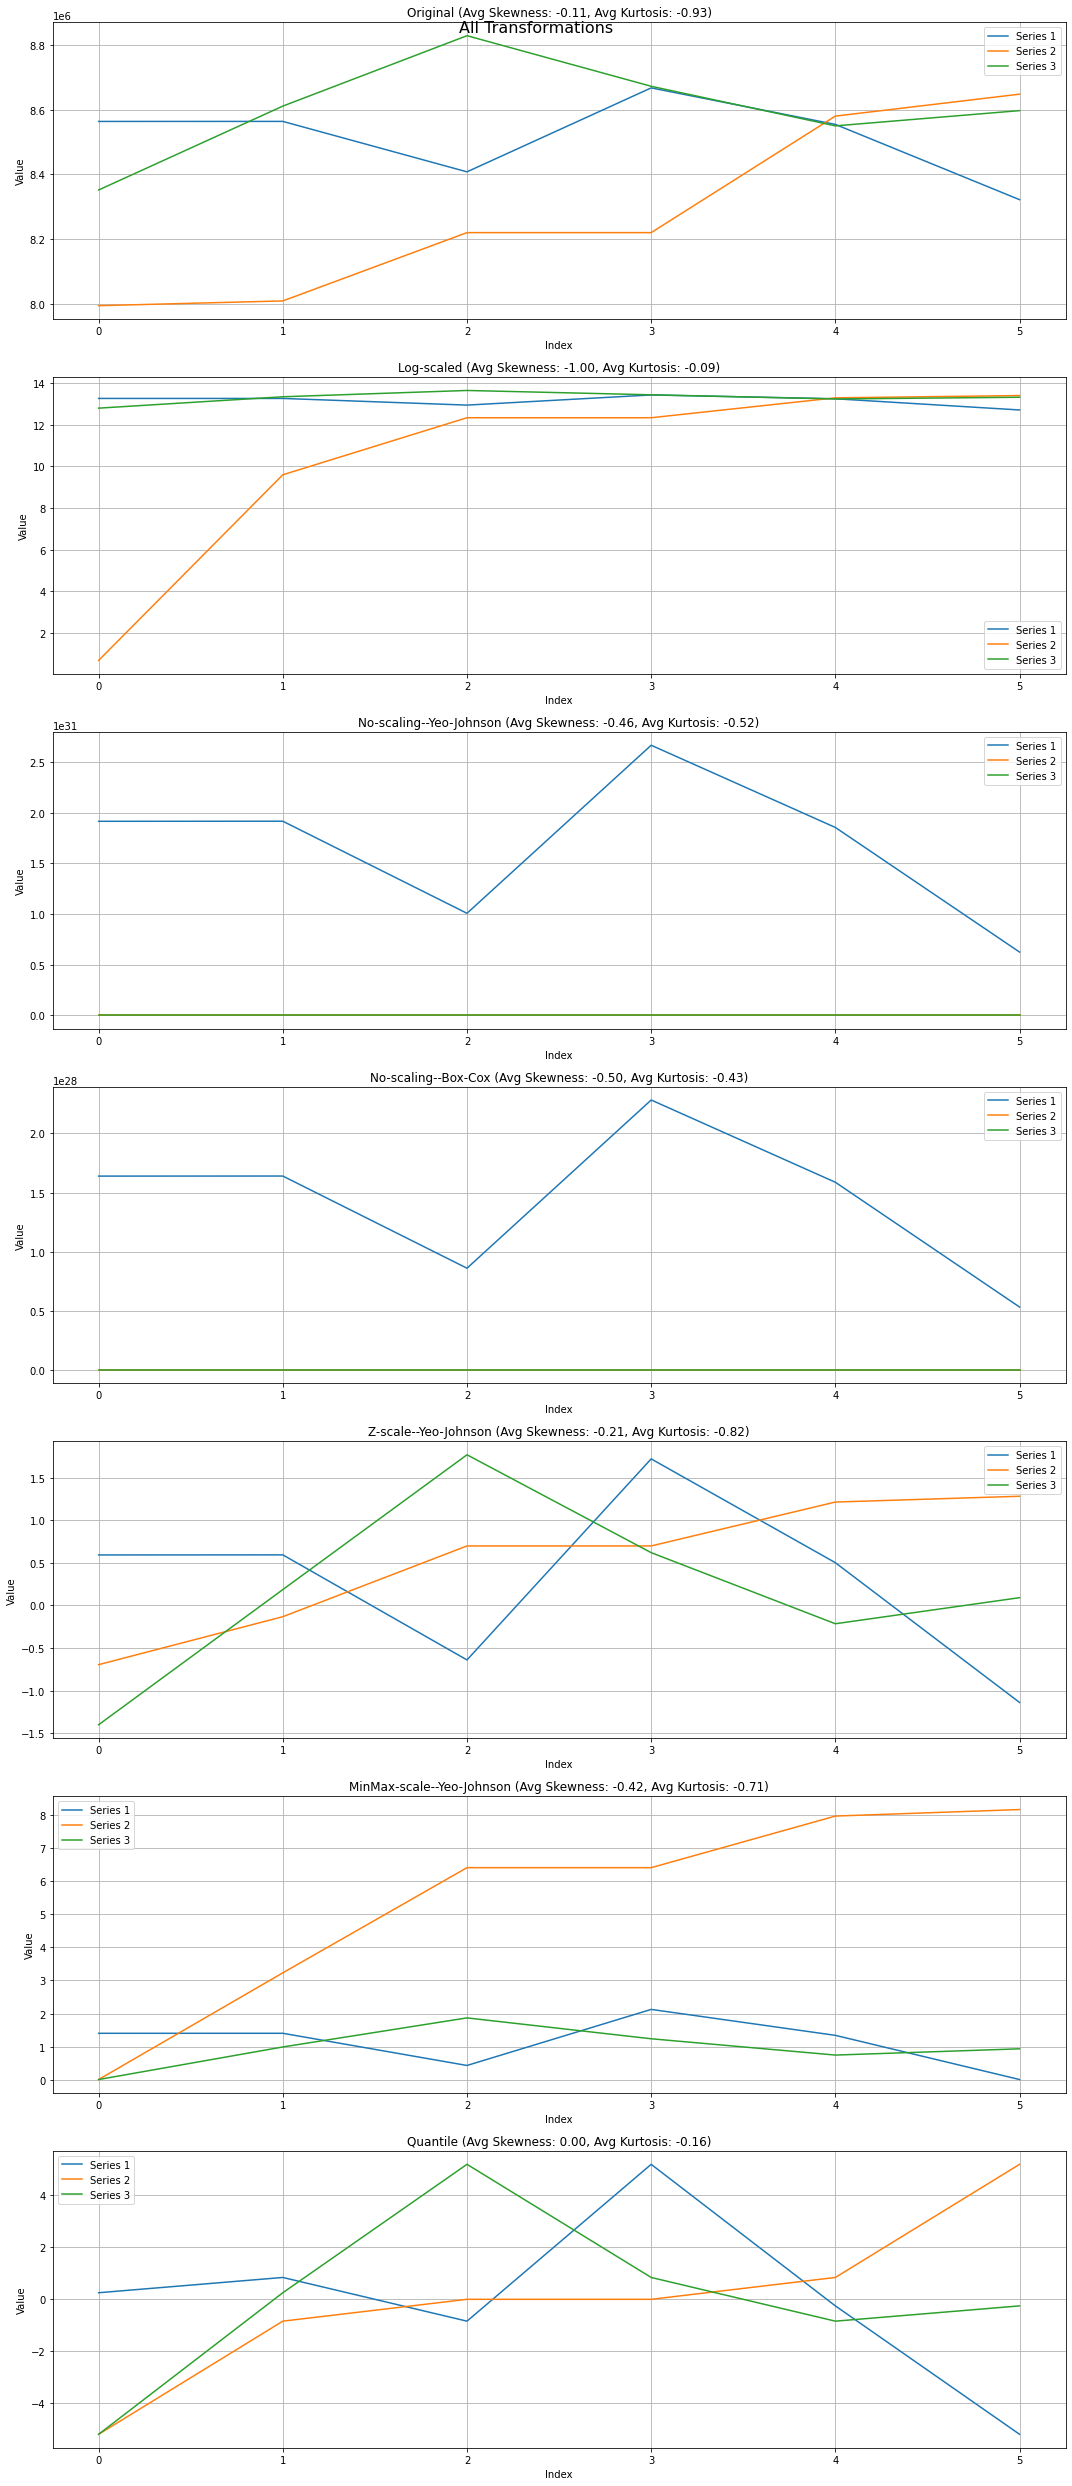

/Users/romanroman/miniforge3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


In [14]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

def safe_log(x):
    return np.log1p(x - np.min(x) + 1)  # Ensure all values are positive before log

def calculate_stats(data):
    skewness = stats.skew(data, axis=0)
    kurtosis = stats.kurtosis(data, axis=0)
    return skewness, kurtosis

def apply_power_transformations(data, prefix=''):
    transformations = {}
    pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    transformations[f'{prefix}Yeo-Johnson'] = pt_yj.fit_transform(data)
    
    if np.all(data > 0):
        pt_bc = PowerTransformer(method='box-cox', standardize=False)
        transformations[f'{prefix}Box-Cox'] = pt_bc.fit_transform(data)
    else:
        print(f"Warning: {prefix}Box-Cox transformation not applied due to non-positive values.")
    
    return transformations

def transform_timeseries(data):
    # Apply safe log transformation to all data first
    log_data = safe_log(data)
    
    transformations = {'Original': data, 'Log-scaled': log_data}
    
    # No pre-scaling
    transformations.update(apply_power_transformations(log_data, 'No-scaling--'))
    
    # Z-scale pre-scaling
    ss = StandardScaler()
    z_scaled = ss.fit_transform(log_data)
    transformations.update(apply_power_transformations(z_scaled, 'Z-scale--'))
    
    # MinMax-scale pre-scaling
    mms = MinMaxScaler()
    minmax_scaled = mms.fit_transform(log_data)
    transformations.update(apply_power_transformations(minmax_scaled, 'MinMax-scale--'))

    # Quantile transform
    qt = QuantileTransformer(output_distribution='normal')
    transformations['Quantile'] = qt.fit_transform(log_data)

    # Calculate skewness and kurtosis for each transformation
    stats_results = {name: calculate_stats(transformed_data) for name, transformed_data in transformations.items()}

    return transformations, stats_results

def calculate_average_statistics(stats_results):
    average_stats = {}
    for method, (skewness, kurtosis) in stats_results.items():
        average_stats[method] = (np.mean(skewness), np.mean(kurtosis))
    return average_stats

def select_best_transformation(average_stats):
    return min(average_stats.items(), key=lambda x: np.mean(np.abs(x[1][0])))

def visualize_transformations(transformations, stats_results):
    n_transformations = len(transformations)
    n_series = transformations['Original'].shape[1]
    fig, axs = plt.subplots(n_transformations, 1, figsize=(15, 5 * n_transformations))
    fig.suptitle(f'All Transformations', fontsize=16)

    for i, (name, data) in enumerate(transformations.items()):
        for j in range(n_series):
            axs[i].plot(data[:, j], label=f'Series {j+1}')
        axs[i].set_title(f'{name} (Avg Skewness: {np.mean(stats_results[name][0]):.2f}, Avg Kurtosis: {np.mean(stats_results[name][1]):.2f})')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('Value')
        axs[i].grid(True)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def apply_final_transformation(data, best_transformation):
    log_data = safe_log(data)
    
    if best_transformation == 'Quantile':
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data = qt.fit_transform(log_data)
    elif best_transformation == 'Log-scaled':
        transformed_data = log_data
    else:
        # Extract the pre-scaling method and power transform method
        pre_scaling, power_transform = best_transformation.split('--')

        # Apply pre-scaling
        if pre_scaling == 'No-scaling':
            scaled_data = log_data
        elif pre_scaling == 'Z-scale':
            ss = StandardScaler()
            scaled_data = ss.fit_transform(log_data)
        elif pre_scaling == 'MinMax-scale':
            mms = MinMaxScaler()
            scaled_data = mms.fit_transform(log_data)
        else:
            raise ValueError(f"Unknown pre-scaling method: {pre_scaling}")

        # Apply power transform
        if power_transform == 'Yeo-Johnson':
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_data = pt.fit_transform(scaled_data)
        elif power_transform == 'Box-Cox':
            pt = PowerTransformer(method='box-cox', standardize=False)
            transformed_data = pt.fit_transform(scaled_data)
        else:
            raise ValueError(f"Unknown power transform method: {power_transform}")

    # Apply final z-scoring
    final_ss = StandardScaler()
    final_transformed_data = final_ss.fit_transform(transformed_data)

    return final_transformed_data

def analyze_timeseries(data):
    transformations, stats_results = transform_timeseries(data)
    
    visualize_transformations(transformations, stats_results)

    average_stats = calculate_average_statistics(stats_results)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    # Create summary DataFrame with ranking
    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': np.mean(skewness), 
         'Average Kurtosis': np.mean(kurtosis)}
        for method, (skewness, kurtosis) in stats_results.items()
    ])
    
    # Sort by absolute value of Average Skewness and add Rank column
    summary_df['Abs Skewness'] = summary_df['Average Skewness'].abs()
    summary_df = summary_df.sort_values('Abs Skewness')
    summary_df['Rank'] = range(1, len(summary_df) + 1)
    
    # Reorder columns and drop 'Abs Skewness'
    summary_df = summary_df[['Rank', 'Transformation', 'Average Skewness', 'Average Kurtosis']]

    final_transformed_data = apply_final_transformation(data, best_transformation)

    return best_transformation, summary_df, final_transformed_data, transformations

# Original time series
time_series_list = [
    [8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53],
    [7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63],
    [8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15],
    # Add more time series as needed
]
# df = pd.DataFrame(time_series_list)
# display(df)
# Convert list of arrays to 2D array, automatically padding with NaN
combined_series = np.array(time_series_list, dtype=float).T

# Remove any rows with NaN values
combined_series = combined_series[~np.isnan(combined_series).any(axis=1)]

# timeseries1 = np.array([8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53])
# timeseries2 = np.array([7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63])
# timeseries3 = np.array([8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15])
# import pandas as pd
# # Combine and reshape for sklearn (samples x features)
# combined_series = np.column_stack((timeseries1, timeseries2, timeseries3))
df = pd.DataFrame(combined_series)
display(df)
best_transformation, summary_df, final_transformed_data, all_transformations = analyze_timeseries(combined_series)

# print("Decision Table for Selecting the Best Transformation (Ranked by Absolute Skewness):")
# print(summary_df.to_string(index=False))
# print(f"\nBest transformation: {best_transformation}")

# # Visualize original vs final transformed data
# plt.figure(figsize=(15, 10))
# plt.subplot(211)
# plt.title("Original Data")
# for i in range(combined_series.shape[1]):
#     plt.plot(combined_series[:, i], label=f'Series {i+1}')
# plt.legend()
# plt.ylabel('Value')

# plt.subplot(212)
# plt.title(f"Final Transformed Data (Best: {best_transformation})")
# for i in range(final_transformed_data.shape[1]):
#     plt.plot(final_transformed_data[:, i], label=f'Series {i+1}')
# plt.legend()
# plt.xlabel('Index')
# plt.ylabel('Value')

# plt.tight_layout()
# plt.show()

/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:964: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/Users/romanroman/miniforge3/lib/python3.8/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/romanroman/miniforge3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:962: RuntimeWarning: overflow encountered in square
  s = s**2


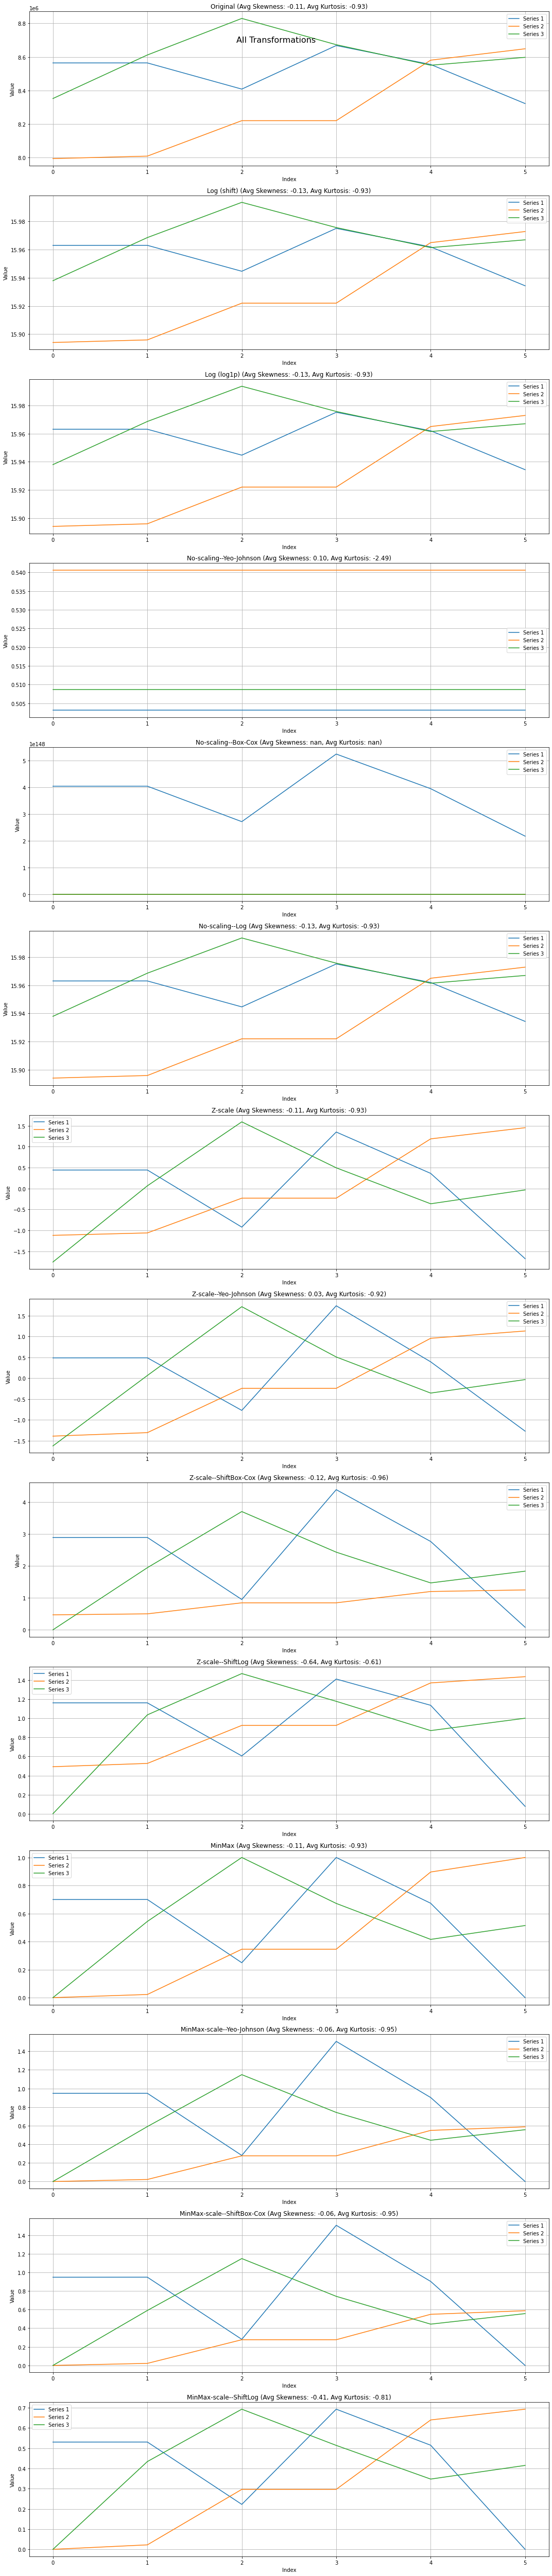

{'Original': (array([-0.4672122 ,  0.3536127 , -0.21566107]), array([-0.99887871, -1.45456408, -0.33304972])), 'Log (shift)': (array([-0.48292096,  0.33403386, -0.25593513]), array([-0.99445074, -1.45783254, -0.32318003])), 'Log (log1p)': (array([-0.48292096,  0.33403386, -0.25593513]), array([-0.99445074, -1.45783254, -0.32318003])), 'No-scaling--Yeo-Johnson': (array([0.        , 0.30062263, 0.        ]), array([-3.        , -1.46198364, -3.        ])), 'No-scaling--Box-Cox': (array([        nan,  0.        , -0.01238356]), array([        nan, -3.        , -0.36047244])), 'No-scaling--Log': (array([-0.48292096,  0.33403386, -0.25593513]), array([-0.99445074, -1.45783254, -0.32318003])), 'Z-scale': (array([-0.4672122 ,  0.3536127 , -0.21566107]), array([-0.99887871, -1.45456408, -0.33304972])), 'Z-scale--Yeo-Johnson': (array([-0.00403872,  0.1014566 ,  0.00514646]), array([-0.92025137, -1.47951846, -0.36137508])), 'Z-scale--ShiftBox-Cox': (array([-0.28092972,  0.03577132, -0.10746924])

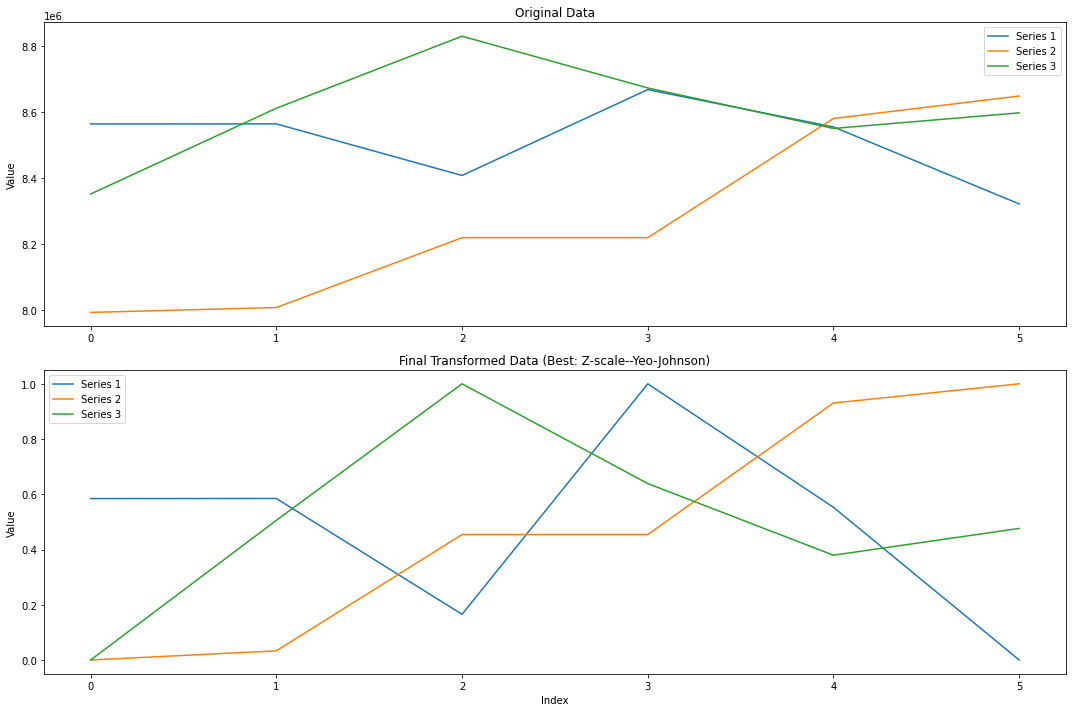

In [29]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

def safe_log(x, method='shift'):
    if method == 'shift':
        min_val = np.min(x)
        if min_val <= 0:
            return np.log(x - min_val + 1)
        else:
            return np.log(x)
    elif method == 'log1p':
        return np.log1p(x)
    else:
        raise ValueError("Invalid method. Choose 'shift' or 'log1p'.")
def safe_box(x, method='shift'):
    pt_bc = PowerTransformer(method='box-cox', standardize=False)
    if method == 'shift':
        min_val = np.min(x)
        if min_val <= 0:
            return pt_bc.fit_transform(x - min_val + 1)
        else:
            return pt_bc.fit_transform(x)
    else:
        raise ValueError("Invalid method. Choose 'shift'.")


def calculate_stats(data):
    skewness = stats.skew(data, axis=0)
    kurtosis = stats.kurtosis(data, axis=0)
    return skewness, kurtosis

def apply_power_transformations(data, prefix=''):
    transformations = {}
    pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    transformations[f'{prefix}Yeo-Johnson'] = pt_yj.fit_transform(data)
    
    if np.all(data > 0):
        pt_bc = PowerTransformer(method='box-cox', standardize=False)
        transformations[f'{prefix}Box-Cox'] = pt_bc.fit_transform(data)
        transformations[f'{prefix}Log'] = np.log(data)
    else:
        transformations[f'{prefix}ShiftBox-Cox'] = safe_box(data)
        transformations[f'{prefix}ShiftLog'] = safe_log(data)
       
        print(f"Warning: {prefix}Box-Cox transformation not applied due to non-positive values.")
    
    return transformations

def transform_timeseries(data):
    transformations = {'Original': data}
    
    # Log transformations
    transformations['Log (shift)'] = safe_log(data, method='shift')
    transformations['Log (log1p)'] = safe_log(data, method='log1p')

    # No pre-scaling
    transformations.update(apply_power_transformations(data, 'No-scaling--'))
    
    # Z-scale pre-scaling
    ss = StandardScaler()
    z_scaled = ss.fit_transform(data)
    transformations['Z-scale'] = z_scaled
    transformations.update(apply_power_transformations(z_scaled, 'Z-scale--'))
    
    # MinMax-scale pre-scaling
    mms = MinMaxScaler()
    minmax_scaled = mms.fit_transform(data)
    transformations['MinMax'] = minmax_scaled
    transformations.update(apply_power_transformations(minmax_scaled, 'MinMax-scale--'))

    # # Quantile transform
    # qt = QuantileTransformer(output_distribution='normal')
    # transformations['Quantile'] = qt.fit_transform(data)

    # Calculate skewness and kurtosis for each transformation
    stats_results = {name: calculate_stats(transformed_data) for name, transformed_data in transformations.items()}

    return transformations, stats_results
def calculate_average_statistics(stats_results):
    print(stats_results)
    #display(pd.DataFrame(stats_results))
    average_stats = {}
    for method, (skewness, kurtosis) in stats_results.items():
        print(method, skewness, kurtosis)
        average_stats[method] = (np.mean(skewness), np.mean(kurtosis))
    return average_stats

def select_best_transformation(average_stats):
    return min(average_stats.items(), key=lambda x: np.mean(np.abs(x[1][0])))
def apply_final_transformation(data, best_transformation):
    if best_transformation.startswith('Log'):
        method = 'shift' if best_transformation == 'Log (shift)' else 'log1p'
        transformed_data = safe_log(data, method=method)
    elif best_transformation == 'Quantile':
        qt = QuantileTransformer(output_distribution='normal')
        transformed_data = qt.fit_transform(data)
    elif best_transformation == 'Z-scale':
        ss = StandardScaler()
        return ss.fit_transform(data)
    elif best_transformation == 'MinMax':
        mms = MinMaxScaler()
        transformed_data = mms.fit_transform(data)
        
    else:
        # Extract the pre-scaling method and power transform method
        pre_scaling, power_transform = best_transformation.split('--')

        # Apply pre-scaling
        if pre_scaling == 'No-scaling':
            scaled_data = data
        elif pre_scaling == 'Z-scale':
            ss = StandardScaler()
            scaled_data = ss.fit_transform(data)
        elif pre_scaling == 'MinMax-scale':
            mms = MinMaxScaler()
            scaled_data = mms.fit_transform(data)
        else:
            raise ValueError(f"Unknown pre-scaling method: {pre_scaling}")

        # Apply power transform
        if power_transform == 'Yeo-Johnson':
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed_data = pt.fit_transform(scaled_data)
        elif power_transform == 'Box-Cox':
            if np.all(scaled_data > 0):
                pt = PowerTransformer(method='box-cox', standardize=False)
                transformed_data = pt.fit_transform(scaled_data)
            else:
                raise ValueError("Box-Cox transform requires positive values")
        elif power_transform == 'ShiftBox-Cox':              
                transformed_data = safe_box(scaled_data)
        elif power_transform == 'Log':
            if np.all(scaled_data > 0):
                transformed_data = np.log(scaled_data)
        elif power_transform == 'ShiftLog':
           
                transformed_data = safe_log(scaled_data)   
        else:
            raise ValueError(f"Unknown power transform method: {power_transform}")
        # Apply final z-scoring
        final_ss = StandardScaler()
        transformed_data = final_ss.fit_transform(transformed_data)
            # Final MinMax scaling to ensure output is between 0 and 1
        final_scaler = MinMaxScaler()
        transformed_data = final_scaler.fit_transform(transformed_data)

        return transformed_data

def analyze_timeseries(data):
    transformations, stats_results = transform_timeseries(data)
    
    visualize_transformations(transformations, stats_results)

    average_stats = calculate_average_statistics(stats_results)
    best_transformation, (best_skewness, best_kurtosis) = select_best_transformation(average_stats)

    # Create summary DataFrame with ranking
    summary_df = pd.DataFrame([
        {'Transformation': method, 
         'Average Skewness': np.mean(skewness), 
         'Average Kurtosis': np.mean(kurtosis)}
        for method, (skewness, kurtosis) in stats_results.items()
    ])
    
    # Sort by absolute value of Average Skewness and add Rank column
    summary_df['Abs Skewness'] = summary_df['Average Skewness'].abs()
    summary_df = summary_df.sort_values('Abs Skewness')
    summary_df['Rank'] = range(1, len(summary_df) + 1)
    
    # Reorder columns and drop 'Abs Skewness'
    summary_df = summary_df[['Rank', 'Transformation', 'Average Skewness', 'Average Kurtosis']]

    final_transformed_data = apply_final_transformation(data, best_transformation)

    return best_transformation, summary_df, final_transformed_data, transformations


# Example usage
time_series_list = [
    np.array([8563757.43, 8563856.3, 8407700.46, 8667598.71, 8554589.31, 8321525.53]),
    np.array([7993292.79, 8007972.38, 8219446.14, 8219446.14, 8580255.29, 8648163.63]),
    np.array([8351520.43, 8611210.76, 8829227.15, 8672594.83, 8550007.98, 8597251.15]),
]

combined_series = np.array(time_series_list, dtype=float).T
combined_series = combined_series[~np.isnan(combined_series).any(axis=1)]

best_transformation, summary_df, final_transformed_data, all_transformations = analyze_timeseries(combined_series)

print("Decision Table for Selecting the Best Transformation (Ranked by Absolute Skewness):")
print(summary_df.to_string(index=False))
print(f"\nBest transformation: {best_transformation}")

# Visualize original vs final transformed data
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.title("Original Data")
for i in range(combined_series.shape[1]):
    plt.plot(combined_series[:, i], label=f'Series {i+1}')
plt.legend()
plt.ylabel('Value')

plt.subplot(212)
plt.title(f"Final Transformed Data (Best: {best_transformation})")
for i in range(final_transformed_data.shape[1]):
    plt.plot(final_transformed_data[:, i], label=f'Series {i+1}')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [1]:
import numpy as np
from scipy.interpolate import splrep, BSpline

# Given values
x_axis = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                   17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
                   32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                   46, 47, 48, 49])

series = [0.9340329911306393, 0.7663512805573902, 0.6579499112045923, 0.8238963816246643,
          0.6475197955701631, 0.9689443971742911, 0.7139579478647715, 0.9246586095822468,
          0.517131892010638, 0.11706441298186265, 0.5281777214230171, 0.1268728280630933,
          0.592493479176405, 0.48249306052766294, 0.6225753978327817, 0.010046981054831594,
          0.1948404916553641, 0.4913304319121309, 0.9505035615891348, 0.3836090403551584,
          0.42437202605363467, 0.7146960890066222, 0.603792757286118, 0.29892615009833323,
          0.4108163955674278, 0.21769979885723245, 0.9660214591302085, 0.13063438155735974,
          0.37183678456641944, 0.02583897222001119, 0.2217794919335464, 0.7804711383801549,
          0.20117523228887946, 0.0800634025289656, 0.4744531798445233, 0.009969234734518495,
          0.08476615442633317, 0.8076258695629751, 0.7714733448596064, 0.915138820404896,
          0.8545154359107495, 0.6831755632398181, 0.05233285730066284, 0.7828486179866575,
          0.8455108108405605, 0.7990821457719545, 0.5084790353080261, 0.23290183864948166,
          0.8453299756887267, 0.7271628097401385]

# Knot positions
knot_positions = np.array([0, 2, 5, 7, 10, 12, 15, 18, 20, 23, 25, 28, 30, 33, 36, 38, 41, 43, 46, 49])

# Spline degree
spline_degree = 3

# Pad the knot vector with `spline_degree + 1` copies of the boundary knots
t = np.concatenate(([knot_positions[0]] * (spline_degree + 1),
                    knot_positions,
                    [knot_positions[-1]] * (spline_degree + 1)))

# Pad the knot vector with `spline_degree + 1` copies of the boundary knots



# Calculate the B-spline coefficients
tck = splrep(x_axis, series, t=t, k=spline_degree)

# Construct the B-spline using the knot vector and coefficients
spline_curve = BSpline(tck[0], tck[1], tck[2])

# Generate the y values for the B-spline curve
spline_y_values = spline_curve(x_axis)

# Plot the results
import matplotlib.pyplot as plt

plt.plot(x_axis, series, 'bo', label='Original Data')
plt.plot(x_axis, spline_y_values, 'r-', label='B-Spline Curve')
plt.legend()
plt.show()


ValueError: Error on input data

In [3]:
import numpy as np
from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt

# Given values
x_axis = np.arange(50)  # Time axis
series = [
    0.9340329911306393, 0.7663512805573902, 0.6579499112045923, 0.8238963816246643,
    0.6475197955701631, 0.9689443971742911, 0.7139579478647715, 0.9246586095822468,
    0.517131892010638, 0.11706441298186265, 0.5281777214230171, 0.1268728280630933,
    0.592493479176405, 0.48249306052766294, 0.6225753978327817, 0.010046981054831594,
    0.1948404916553641, 0.4913304319121309, 0.9505035615891348, 0.3836090403551584,
    0.42437202605363467, 0.7146960890066222, 0.603792757286118, 0.29892615009833323,
    0.4108163955674278, 0.21769979885723245, 0.9660214591302085, 0.13063438155735974,
    0.37183678456641944, 0.02583897222001119, 0.2217794919335464, 0.7804711383801549,
    0.20117523228887946, 0.0800634025289656, 0.4744531798445233, 0.009969234734518495,
    0.08476615442633317, 0.8076258695629751, 0.7714733448596064, 0.915138820404896,
    0.8545154359107495, 0.6831755632398181, 0.05233285730066284, 0.7828486179866575,
    0.8455108108405605, 0.7990821457719545, 0.5084790353080261, 0.23290183864948166,
    0.8453299756887267, 0.7271628097401385
]

# Specified knot positions
knot_positions = np.array([0, 2, 5, 7, 10, 12, 15, 18, 20, 23, 25, 28, 30, 33, 36, 38, 41, 43, 46, 49])
knot_positions = np.linspace(0, len(series) - 1, 10)
# Spline degree
spline_degree = 3

# Ensure the knots are in the correct format with padding
# t = np.concatenate((
#     [knot_positions[0]] * spline_degree,
#     knot_positions,
#     [knot_positions[-1]] * spline_degree
# ))

# Calculate the B-spline coefficients
tck = splrep(x_axis, series, t=knot_positions, k=spline_degree)

# Construct the B-spline using the knot vector and coefficients
spline_curve = BSpline(tck[0], tck[1], tck[2])

# Generate the y values for the B-spline curve
spline_y_values = spline_curve(x_axis)

# Plot the results
plt.plot(x_axis, series, 'bo', label='Original Data')
plt.plot(x_axis, spline_y_values, 'r-', label='B-Spline Curve')
plt.legend()
plt.show()


ValueError: Error on input data

In [4]:
import numpy as np
from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt

# Given values
x_axis = np.arange(50)  # Time axis
series = [
    0.9340329911306393, 0.7663512805573902, 0.6579499112045923, 0.8238963816246643,
    0.6475197955701631, 0.9689443971742911, 0.7139579478647715, 0.9246586095822468,
    0.517131892010638, 0.11706441298186265, 0.5281777214230171, 0.1268728280630933,
    0.592493479176405, 0.48249306052766294, 0.6225753978327817, 0.010046981054831594,
    0.1948404916553641, 0.4913304319121309, 0.9505035615891348, 0.3836090403551584,
    0.42437202605363467, 0.7146960890066222, 0.603792757286118, 0.29892615009833323,
    0.4108163955674278, 0.21769979885723245, 0.9660214591302085, 0.13063438155735974,
    0.37183678456641944, 0.02583897222001119, 0.2217794919335464, 0.7804711383801549,
    0.20117523228887946, 0.0800634025289656, 0.4744531798445233, 0.009969234734518495,
    0.08476615442633317, 0.8076258695629751, 0.7714733448596064, 0.915138820404896,
    0.8545154359107495, 0.6831755632398181, 0.05233285730066284, 0.7828486179866575,
    0.8455108108405605, 0.7990821457719545, 0.5084790353080261, 0.23290183864948166,
    0.8453299756887267, 0.7271628097401385
]

# Spline degree
spline_degree = 3

# Specified knot positions (ensuring they are within valid bounds)
knot_positions = np.linspace(0, len(series) - 1, 10)

# Calculate the B-spline coefficients
tck = splrep(x_axis, series, t=knot_positions, k=spline_degree)

# Construct the B-spline using the knot vector and coefficients
spline_curve = BSpline(tck[0], tck[1], tck[2])

# Generate the y values for the B-spline curve
spline_y_values = spline_curve(x_axis)

# Plot the results
plt.plot(x_axis, series, 'bo', label='Original Data')
plt.plot(x_axis, spline_y_values, 'r-', label='B-Spline Curve')
plt.legend()
plt.show()


ValueError: Error on input data

len series 50
leng of knots 20
knot_positions 18
knot_positions [ 1  3  6  9 12 14 17 20 23 25 28 31 34 36 39 42 45 48]
t [ 0.  0.  0.  0.  0.  0.  1.  3.  6.  9. 12. 14. 17. 20. 23. 25. 28. 31.
 34. 36. 39. 42. 45. 48. 49. 49. 49. 49. 49. 49.]
len t 30
c [ 0.93403299  5.33727605 -1.30801859  2.21932041 -0.74558595  2.58097735
 -1.04357094  1.29932285 -0.13876298  0.48787199  1.02274702 -0.06842471
  1.01950032 -0.28115353  0.69071966  0.26505737 -0.43155918  2.5560081
 -1.79509716  2.92799576 -0.76014867  0.37717339  2.29576571  0.72716281
  0.          0.          0.          0.          0.          0.        ]
len c 30
k 5
len(spline_curve) <scipy.interpolate._bsplines.BSpline object at 0x137b00490>
len(knot_indices) 30


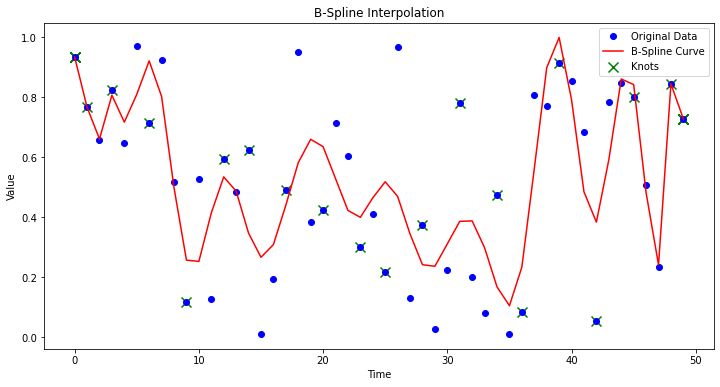

In [37]:
import numpy as np
from scipy.interpolate import splrep, BSpline
import matplotlib.pyplot as plt

# Given values
x_axis = np.arange(50)  # Time axis
series = [
    0.9340329911306393, 0.7663512805573902, 0.6579499112045923, 0.8238963816246643,
    0.6475197955701631, 0.9689443971742911, 0.7139579478647715, 0.9246586095822468,
    0.517131892010638, 0.11706441298186265, 0.5281777214230171, 0.1268728280630933,
    0.592493479176405, 0.48249306052766294, 0.6225753978327817, 0.010046981054831594,
    0.1948404916553641, 0.4913304319121309, 0.9505035615891348, 0.3836090403551584,
    0.42437202605363467, 0.7146960890066222, 0.603792757286118, 0.29892615009833323,
    0.4108163955674278, 0.21769979885723245, 0.9660214591302085, 0.13063438155735974,
    0.37183678456641944, 0.02583897222001119, 0.2217794919335464, 0.7804711383801549,
    0.20117523228887946, 0.0800634025289656, 0.4744531798445233, 0.009969234734518495,
    0.08476615442633317, 0.8076258695629751, 0.7714733448596064, 0.915138820404896,
    0.8545154359107495, 0.6831755632398181, 0.05233285730066284, 0.7828486179866575,
    0.8455108108405605, 0.7990821457719545, 0.5084790353080261, 0.23290183864948166,
    0.8453299756887267, 0.7271628097401385
]
print('len series', len(series))
# Spline degree
spline_degree = 5

# Calculate the number of knots
n_knots = len(x_axis) - spline_degree + 1
n_knots = 20
print('leng of knots', n_knots)
PADDING = 1
# Create knot positions (excluding the endpoints)
knot_positions = np.linspace(x_axis[1], x_axis[-2], n_knots - 2, dtype=int)
print('knot_positions',len(knot_positions))
print('knot_positions',knot_positions)
spline_knots = 10
#knot_positions = np.linspace(PADDING, len(series) - PADDING, spline_knots)
#print (knot_positions)
try:
    # Calculate the B-spline coefficients
    t, c, k = splrep(x_axis, series, t=knot_positions, k=spline_degree)
    print('t',t)
    print('len t', len(t))
    print('c',c)
    print('len c', len(c))
    print('k',k)
    # Construct the B-spline using the knot vector and coefficients
    spline_curve = BSpline(t, c, k)
    print('len(spline_curve)',spline_curve)
    # Generate the y values for the B-spline curve
    spline_y_values = spline_curve(x_axis)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(x_axis, series, 'bo', label='Original Data')
    plt.plot(x_axis, spline_y_values, 'r-', label='B-Spline Curve')
    # Scatter plot for knots
    knot_indices = np.clip(t.astype(int), 0, len(x_axis) - 1)
    print('len(knot_indices)', len(knot_indices))
    plt.scatter(x_axis[knot_indices], 
                np.array(series)[knot_indices], 
                marker='x', 
                color='g',
                s=100,
                label='Knots')

    plt.legend()
    plt.title('B-Spline Interpolation')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

except ValueError as e:
    print(f"Error occurred: {e}")
    print("Please check your input data and parameters.")

In [38]:
time_series_data = np.array([np.random.rand(50) for _ in range(20)])
print(time_series_data.shape)

(20, 50)


In [40]:
ind = [1,1,7,8,3]
print(time_series_data[ind])

[[9.31137825e-01 5.44301286e-01 4.55002453e-01 1.82531006e-01
  9.13133205e-01 3.18135932e-01 1.39270567e-01 8.24953141e-01
  8.83693689e-01 3.14837437e-01 8.01067416e-01 3.82132659e-01
  6.00650589e-02 3.78418389e-01 1.62282428e-01 1.03559392e-01
  7.71300847e-01 2.51389534e-01 1.56881187e-01 4.61858064e-01
  1.93454203e-01 1.75517389e-01 7.26123662e-01 6.36379157e-01
  1.78385041e-01 1.67243718e-01 2.83940696e-01 4.22080097e-01
  1.38012223e-02 7.49690462e-01 9.56615665e-01 4.94803476e-01
  1.66609283e-01 5.76459179e-01 2.06298789e-01 7.35673508e-01
  3.14681393e-01 1.20447168e-01 1.99182647e-01 2.74036580e-01
  6.67765998e-01 7.54948394e-01 9.91894457e-02 3.01392457e-01
  6.02155805e-01 3.75869633e-01 8.65368762e-01 8.27025321e-01
  4.00266286e-01 1.89595343e-01]
 [9.31137825e-01 5.44301286e-01 4.55002453e-01 1.82531006e-01
  9.13133205e-01 3.18135932e-01 1.39270567e-01 8.24953141e-01
  8.83693689e-01 3.14837437e-01 8.01067416e-01 3.82132659e-01
  6.00650589e-02 3.78418389e-01 1.622

In [93]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline, splev,splrep
from aeon.distances import lcss_distance, erp_distance, edr_distance, msm_distance, twe_distance, dtw_distance, ddtw_distance, wdtw_distance, wddtw_distance
from tslearn.metrics import soft_dtw
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from aeon.clustering import TimeSeriesKMeans, TimeSeriesKMedoids

DISTANCE_FUNCTIONS = {
    'dtw': dtw_distance,
    'ddtw': ddtw_distance,
    'wdtw': wdtw_distance,
    'wddtw': wddtw_distance,
    'lcss': lcss_distance,
    'erp': erp_distance,
    'edr': edr_distance,
    'msm': msm_distance,
    'twe': twe_distance,
    'soft_dtw': soft_dtw,
    'manhattan': lambda x, y: np.sum(np.abs(x - y))
}

class APClustering:
    def __init__(self, distance='dtw', method='affinity', n_clusters=None, averaging_method='mean', use_bspline=False, spline_degree=3, spline_knots=20,gamma=None, distance_params=None):
        self.distance = distance
        self.method = method
        self.n_clusters = n_clusters
        self.averaging_method = averaging_method
        self.use_bspline = use_bspline
        self.spline_degree = spline_degree
        self.spline_knots = spline_knots
        self.gamma = gamma
        self.model = None
        self.cluster_centers_indices_ = None
        self.cluster_centers_ = None
        self.cluster_centers_ts_ = None  # For storing the actual time series if using B-spline
        self.cluster_spline_knots_ = None  # Store knots for each center if using B-spline
        self.thresholds_ = None
        self.distance_params = distance_params if distance_params else {}

    def fit_bspline(self, time_series_list):
        coefficients = []
        knots = []
        PADDING = self.spline_degree
        for series in time_series_list:
            x_axis = np.arange(0, len(series))
            if self.spline_knots is not None:
                knot_positions = np.linspace(PADDING, len(series) - PADDING, self.spline_knots, dtype=int)
                knot_positions = np.linspace(x_axis[1], x_axis[-2], self.spline_knots - 2, dtype=int)
                #knot_positions = np.arange(PADDING, len(series)-PADDING,self.spline_knots)  
            else:
                knot_positions = np.linspace(0, len(series) - 1, len(series) - self.spline_degree - 1, dtype=int)
                
                #knot_positions = self.spline_knots if self.spline_knots is not None else np.linspace(0, len(series)-1, len(series) - self.spline_degree - 1)
            t, c, k = splrep(x_axis, series, t=knot_positions, k=self.spline_degree)
            coefficients.append(c)
            knots.append(t)
        return np.array(coefficients), np.array(knots)

    def fit(self, time_series_list, display_charts=False, num_to_display=10):
        bspline_coefficients = None
        spline_knots = None
        time_series_list =np.array(time_series_list)
        if self.use_bspline:
            bspline_coefficients, spline_knots = self.fit_bspline(time_series_list)

        distance_matrix = self.compute_distance_matrix(bspline_coefficients if self.use_bspline else time_series_list)

        if self.method == 'affinity':
            self.model = AffinityPropagation(affinity='precomputed')
            labels_ = self.model.fit_predict(-distance_matrix)
            self.cluster_centers_indices_ = self.model.cluster_centers_indices_
            self.cluster_centers_ = (bspline_coefficients if self.use_bspline else time_series_list)[self.cluster_centers_indices_]

        elif self.method == 'kmeans':
            self.model = TimeSeriesKMeans(
                n_clusters=self.n_clusters,
                distance=self.distance,
                averaging_method=self.averaging_method,
                init_algorithm="random",
                random_state=1
            )
            self.model.fit(bspline_coefficients if self.use_bspline else time_series_list)
            labels_ = self.model.labels_
            self.cluster_centers_ = self.model.cluster_centers_

            
        elif self.method == 'kmedoids':
            self.model = TimeSeriesKMedoids(
                n_clusters=self.n_clusters,
                init_algorithm='random',
                distance=self.distance,
                random_state=1
            )
            self.model.fit(bspline_coefficients if self.use_bspline else time_series_list)
            labels_ = self.model.labels_
            self.cluster_centers_ = self.model.cluster_centers_

        # Reintroducing threshold calculation for outlier detection
        self.thresholds_ = {}
        for i, center in enumerate(self.cluster_centers_):
            cluster_distances = [
                DISTANCE_FUNCTIONS[self.distance](center.reshape(1, -1), time_series_list[j].reshape(1, -1), **self.distance_params)
                for j in np.where(labels_ == i)[0]
            ]
            self.thresholds_[i] = np.percentile(cluster_distances, 99)
        
        if self.use_bspline:
            if  self.method == 'affinity':
                #self.cluster_centers_ts_,inds_ = self.infer_corresponding_ts(time_series_list, bspline_coefficients, self.cluster_centers_)
                self.cluster_spline_knots_ = spline_knots[self.cluster_centers_indices_]
                self.cluster_centers_ts_ = np.array(time_series_list)[self.cluster_centers_indices_]

                
            else:
                self.cluster_spline_knots_ = spline_knots[:len(self.cluster_centers_)]

        self.evaluate_clustering(time_series_list, labels_)
        self.cluster_statistics(labels_)
        if display_charts:
            #time_series, bspline_coefficients=None, spline_knots=None, labels_=None, num_to_display=10)
            self.get_clusters_chart(time_series_list, bspline_coefficients, spline_knots, labels_,num_to_display=num_to_display)

    def predict(self, new_time_series, display_charts=False, num_to_display=10):
        new_bspline_coefficients = None
        new_spline_knots = None
        if self.use_bspline:
            new_bspline_coefficients, new_spline_knots = self.fit_bspline(new_time_series)

        distances_to_centers = self.compute_distance_matrix_for_new_series(new_bspline_coefficients if self.use_bspline else new_time_series)

        predictions = []
        if self.method == 'affinity':
            for i in range(distances_to_centers.shape[0]):
                predicted_label = np.argmin(distances_to_centers[i])

                if distances_to_centers[i, predicted_label] > self.thresholds_[predicted_label]:
                    predictions.append(-1)  # Indicate an outlier
                else:
                    predictions.append(predicted_label)

        elif self.method == 'kmeans' or self.method == 'kmedoids':
            new_time_series = np.array(new_time_series)
            prediction_labels = self.model.predict(new_bspline_coefficients if self.use_bspline else new_time_series)
            for i in range(distances_to_centers.shape[0]):
                predicted_label = prediction_labels[i]

                if distances_to_centers[i, predicted_label] > self.thresholds_[predicted_label]:
                    predictions.append(-1)  # Indicate an outlier
                else:
                    predictions.append(predicted_label)

        if display_charts:
            self.get_clusters_chart(new_time_series, new_bspline_coefficients, new_spline_knots, np.array(predictions), num_to_display=num_to_display)

        return np.array(predictions)

    def compute_distance_matrix(self, time_series_data):
        n = len(time_series_data)
        distance_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i, n):
                dist = DISTANCE_FUNCTIONS[self.distance](time_series_data[i].reshape(1, -1), time_series_data[j].reshape(1, -1), **self.distance_params)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
        return distance_matrix

    def compute_distance_matrix_for_new_series(self, new_time_series):
        n = len(new_time_series)
        distance_matrix = np.zeros((n, len(self.cluster_centers_)))
        for i in range(n):
            for j, center in enumerate(self.cluster_centers_):
                dist = DISTANCE_FUNCTIONS[self.distance](new_time_series[i].reshape(1, -1), center.reshape(1, -1), **self.distance_params)
                distance_matrix[i, j] = dist
        return distance_matrix

    def infer_corresponding_ts(self, time_series_list, bspline_coefficients, cluster_centers):
        inferred_ts = []
        inds = []
        for center in cluster_centers:
            min_dist = float('inf')
            corresponding_ts = None
            index = np.argmin([np.sum(np.abs(bspline_coefficients[j] - center)) for j in range(len(bspline_coefficients))])
            for i, coeff in enumerate(bspline_coefficients):
                dist = np.linalg.norm(coeff - center)
                if dist < min_dist:
                    min_dist = dist
                    corresponding_ts = time_series_list[i]
                    inds_ = i
            inferred_ts.append(corresponding_ts)
            inds.append(inds_)
        return np.array(inferred_ts),inds

    def get_clusters_chart(self, time_series, bspline_coefficients=None, spline_knots=None, labels_=None, num_to_display=10):
        cluster_indices = {i: np.where(labels_ == i)[0] for i in range(len(self.cluster_centers_))}
        cluster_indices[len(self.cluster_centers_)] = np.where(labels_ == -1)[0]   
        fig, axes = plt.subplots(num_to_display + 1, len(self.cluster_centers_)+1, figsize=(15, 2.5 * (num_to_display + 1)))
        fig.subplots_adjust(hspace=0.5)

        for i in range(len(self.cluster_centers_)+1):
            # Plot the cluster center's B-spline curve and its corresponding original time series
            if i<len(self.cluster_centers_):
                
                if self.use_bspline:
                    if self.method == 'affinity': 
                        x_axis = np.arange(len(self.cluster_centers_ts_[i])) 
                    else:
                        x_axis = np.arange(len(time_series[0]))
                    spline_curve = BSpline(self.cluster_spline_knots_[i], self.cluster_centers_[i].reshape(-1,1), self.spline_degree)(x_axis)
                    axes[0, i].plot(x_axis,spline_curve, color='red', ) #label='Cluster Center (B-Spline)'
                   
                    #print (len(x_axis), len(self.cluster_centers_ts_[i]), len(self.cluster_spline_knots_[i]))
                    knot_indices = np.clip(self.cluster_spline_knots_[i].astype(int), 0, len(x_axis) - 1)
                    if self.method == 'affinity': 
                        axes[0, i].plot(x_axis,self.cluster_centers_ts_[i], color='blue', ) #label='Original TS'
                        axes[0, i].scatter(x_axis[knot_indices],np.array(self.cluster_centers_ts_[i])[knot_indices], color='black', s=10,marker='x',) # label='Knots'
                else:
                    x_axis = (np.arange(len(self.cluster_centers_[i].reshape(-1,1))))
                    axes[0, i].plot(x_axis,self.cluster_centers_[i].reshape(-1,1), color='red', ) #label='Cluster Center'
        
            random_indices = np.random.choice(cluster_indices[i], min(len(cluster_indices[i]), 20), replace=False)
            for index in random_indices:
                axes[0, i].plot(x_axis,time_series[index], color='gray', alpha=0.3)
        
            
            #clearaxes[0, i].legend()
            if i==len(self.cluster_centers_):
                axes[0, i].set_title(f'Outliers')
            else:
                axes[0, i].set_title(f'Cluster {i}')
            
            # Plot individual time series with their B-spline curve in the appropriate cluster column
            for j, idx in enumerate(random_indices[:num_to_display]):
                if self.use_bspline:
                    spline_curve = BSpline(spline_knots[idx], bspline_coefficients[idx], self.spline_degree)(np.arange(len(time_series[idx])))
                    axes[j + 1, i].plot(x_axis,spline_curve, color='red', ) #label='Fitted B-Spline'
                    knot_indices = np.clip(spline_knots[idx].astype(int), 0, len(x_axis) - 1)
                    axes[j + 1, i].scatter(x_axis[knot_indices],time_series[idx][knot_indices], color='black', s=10,marker='x' )
                axes[j + 1, i].plot(x_axis,time_series[idx], color='blue', ) #label='Original TS'
                
                #axes[j + 1, i].legend()
        
        plt.show()
    def cluster_statistics(self,labels_):
        for cluster in range(len(self.cluster_centers_)):
            cluster_indices = np.where(labels_ == cluster)[0]
            print(f"Cluster {cluster}: {len(cluster_indices)} time series")
   
    def evaluate_clustering(self, time_series_list, labels):
        metrics = {}
        metrics['silhouette_score'] = silhouette_score(time_series_list, labels, metric='euclidean')
        metrics['davies_bouldin_score'] = davies_bouldin_score(time_series_list, labels)
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(time_series_list, labels)
        print(f"Clustering evaluation metrics: {metrics}")
        return metrics

import numpy as np

In [98]:

import numpy as np
DISTANCE_FUNCTIONS = {
    'dtw': dtw_distance,
    'ddtw': ddtw_distance,
    'wdtw': wdtw_distance,
    'wddtw': wddtw_distance,
    'lcss': lcss_distance,
    'erp': erp_distance,
    'edr': edr_distance,
    'msm': msm_distance,
    'twe': twe_distance,
    'soft_dtw': soft_dtw,
    'manhattan': lambda x, y: np.sum(np.abs(x - y))
}

# Generate some synthetic time series data for demonstration
#np.random.seed(42)
time_series_data = [np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.1, 100) for _ in range(50)]
new_time_series = [np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.1, 100)]
# Sample time series data
time_series_data = [np.random.rand(50) for _ in range(20)]
new_time_series =  [np.random.rand(50) for _ in range(30)]
# Initialize the APClustering class with desired parameters
clustering_model = APClustering(
    distance='soft_dtw',           # Distance measure to use
    method='kmedoids',          # Clustering method: 'affinity', 'kmeans', or 'kmedoids'
    n_clusters=4,             # Number of clusters (for k-means and k-medoids)
    use_bspline=True,         # Use B-spline fitting
    spline_degree=5,          # Degree of the spline
    spline_knots=20
)

# Fit the model with the time series data
clustering_model.fit(time_series_data, display_charts=True, num_to_display=5)

# Predict clusters for new time series data
predicted_labels = clustering_model.predict(new_time_series, display_charts=True, num_to_display=5)

# Display the predicted labels
print("Predicted Cluster Labels for New Time Series:", predicted_labels)


ValueError: Unknown metric soft_dtw

In [75]:
import numpy as np
from aeon.distances import dtw_pairwise_distance,ddtw_pairwise_distance,shape_dtw_pairwise_distance,wddtw_pairwise_distance
# Distance between each time series in a collection of time series
X = np.array(time_series_data)
print(X.shape)
dist = wddtw_pairwise_distance(X)
print(dist.shape)


(20, 50)
(20, 20)


In [88]:
from aeon.distances import ddtw_distance
time_series_data = np.array(time_series_data)
distance_params= {}
series1=time_series_data[0].reshape(1, -1)
print(series1.shape)
series2=time_series_data[2].reshape(1, -1)
print(series2.shape)

dist = ddtw_distance(series1, series2, **distance_params)
dist

(1, 50)
(1, 50)


2.4995292621770133

In [86]:
x = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
print(x.shape)
y = np.array([[42, 23, 21, 55, 1, 19, 33, 34, 29, 19]])
print(y.shape)
round(ddtw_distance(x, y))

(1, 10)
(1, 10)


2180